In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from google.colab import files
import io
import random
from copy import deepcopy
import math
from matplotlib import pyplot as plt
import datetime as dt
import copy
import requests
import json
import geopy.distance

# INTRODUCTION : Overview of the customer card

,ROUTE_ID,CUSTOMER_NUMBER,CUSTOMER_CODE,CUSTOMER_LATITUDE,CUSTOMER_LONGITUDE,CUSTOMER_TIME_WINDOW_FROM_MIN,CUSTOMER_TIME_WINDOW_TO_MIN,NUMBER_OF_ARTICLES,TOTAL_WEIGHT_KG,TOTAL_VOLUME_M3,CUSTOMER_DELIVERY_SERVICE_TIME_MIN,
0,2946091,1,138087,43.413050,17.875880,480,900,42.0,64.318,0.320,19.94,
1,2946091,2,138157,43.135963,17.776839,480,900,14.0,17.553,0.046,11.36,
2,2946091,3,26,43.469078,17.337022,481,961,4.0,6.378,0.041,8.73,
3,2946091,4,478,43.707160,17.222900,481,961,5.0,16.375,0.046,9.10,
4,2946091,5,921127,43.082228,17.960037,480,840,16.0,18.939,0.074,11.99,


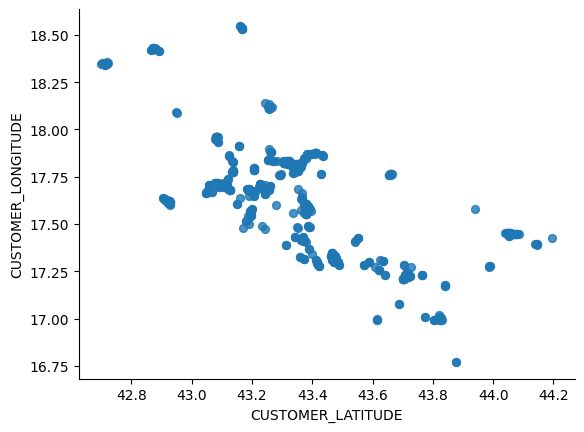

In [ ]:
customers = pd.read_excel('/content/2_detail_table_customers.xls')
customers.plot(kind='scatter', x='CUSTOMER_LATITUDE', y='CUSTOMER_LONGITUDE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

customers.head()

# I) Simulated annealing algorithm part



## 1) Data storage and case for 1 road

In [ ]:
#Loading Excel data as pandas DataFrames
customers = pd.read_excel('/content/2_detail_table_customers.xls')
vehicles = pd.read_excel('/content/3_detail_table_vehicles.xls')
depots = pd.read_excel('/content/4_detail_table_depots.xls')
cust_depot_dist = pd.read_excel('/content/6_detail_table_cust_depots_distances.xls')

In [ ]:
#Limitation to the case of a single road
route_id_list = [2946091, 2922001, 2939484, 2958047, 2970877, 2990001, 3005971, 2604001, 3016355, 3027038, 3044702]
route_id = route_id_list[0]

clients = customers[customers["ROUTE_ID"]==route_id]
vehicules = vehicles[vehicles["ROUTE_ID"]==route_id]
entrepots = depots[depots["ROUTE_ID"]==route_id]
distances_client_depot = cust_depot_dist[cust_depot_dist["ROUTE_ID"]==route_id]

clients.reset_index(drop=True, inplace=True)  # Resets the index from 0
vehicules.reset_index(drop=True, inplace=True)
entrepots.reset_index(drop=True, inplace=True)
distances_client_depot.reset_index(drop=True, inplace=True)

In [ ]:
# Use of dictionnary to access to the data more easily

# Storage of clients position   strcuture : Client-indexed list of lists with longitude and latitude
positions_clients = {}
for i in clients.index:
    positions_clients[i+1] = (clients.loc[i, 'CUSTOMER_LATITUDE'], clients.loc[i, 'CUSTOMER_LONGITUDE'])

# Adding the warehouse position with the index 0
positions_clients[0] = (entrepots.loc[0, 'DEPOT_LATITUDE'], entrepots.loc[0, 'DEPOT_LONGITUDE'])

# Storage of clients articles   strcuture : Client-indexed list of lists with volume and weight
articles_clients = {}
for i in clients.index:
    articles_clients[i+1] = (clients.loc[i, 'TOTAL_VOLUME_M3'], clients.loc[i, 'TOTAL_WEIGHT_KG'])

# Vehicle constraints           strcuture : Indexed list with truck number list with volume, weight and stroke per km
contraintes_vehicules = {}
for i in vehicules.index:
    contraintes_vehicules[i+1] = (vehicules.loc[i, 'VEHICLE_TOTAL_VOLUME_M3'], vehicules.loc[i, 'VEHICLE_TOTAL_WEIGHT_KG'], vehicules.loc[i, 'VEHICLE_VARIABLE_COST_KM'])

In [ ]:
# Overview on one dictionnary

positions_clients

{1: (43.41305, 17.87588),
 2: (43.135963, 17.776839),
 3: (43.46907801, 17.33702249),
 4: (43.70716, 17.2229),
 5: (43.08222786, 17.96003741),
 6: (43.46470189, 17.31043644),
 7: (43.35266, 17.80444),
 8: (43.48189308, 17.30045863),
 9: (43.35459, 17.79902),
 10: (43.396088, 17.871369),
 11: (43.71657, 17.23185),
 12: (43.11036, 17.70165),
 13: (43.71619, 17.2317),
 14: (43.54998018, 17.42732548),
 15: (43.475001, 17.325417),
 16: (43.33841, 17.79242),
 17: (43.111171, 17.69928539),
 18: (43.34568, 17.80545),
 19: (43.36378, 17.82157),
 20: (43.32605, 17.82229),
 21: (43.224819, 17.695885),
 22: (43.71695937, 17.23264032),
 23: (43.46991226, 17.3333838),
 24: (43.36369616, 17.8181746),
 25: (43.34521, 17.7901),
 26: (43.71342, 17.23878),
 27: (43.429906, 17.7661),
 28: (43.11155, 17.71267),
 29: (43.586910367012, 17.298542261123),
 30: (43.71763, 17.22673),
 31: (43.71489, 17.22924),
 32: (43.71959, 17.22727),
 33: (43.63608, 17.30644),
 34: (43.72212, 17.22354),
 35: (43.4744, 17.3281

## 2) Computation of the distance between 2 clients

In [ ]:
# Functions to compute the position and distance of the clients

def position_client(num_client):
  """
  Return the longitude and the latitude of a client.
  parameter :
  - num_client : client number
  return :
  - (longitude, latitude) of the client
  """
  return positions_clients[num_client]

# Compute the distance between 2 points using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
  """
  Compute the circle distance in kilometers between two points
  on the Earth (specified in decimal degrees).
  parameters :
  - lat1, lon1 : position of the first point
  - lat2, lon2 : position of the second point
  return :
  - c*r : distance between both points
  """
  # Convert decimal degrees to radians
  lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

  # Haversine formula
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  r = 6371  # rayon terre
  return c * r

def calcul_distance(client1, client2):
  """
  Compute the distance between 2 clients.
  parameters :
  - client1, client2 : clients
  return :
  - distance between both clients
  """
  lat_client_1, lon_client_1 = position_client(client1)
  lat_client_2, lon_client_2 = position_client(client2)
  return haversine(lat_client_1, lon_client_1, lat_client_2, lon_client_2)


## 3) Generation et validation of schedulings

In [ ]:
#Function to generate a random scheduling

def generer_ordonnancement_aleatoire(nb_clients, nb_vehicles_max):
  """
  Generates a random scheduling of customers with a maximum number of vehicles.
  parameters :
  - nb_clients : Number of clients in the scheduling
  - nb_vehicles_max : maximum number of vehicles
  return :
  - ordonnancement : a scheduling
  """
  ordonnancement = [[] for _ in range(nb_vehicles_max)]
  liste_clients = list(range(1, nb_clients + 1))
  random.shuffle(liste_clients)
  for client in liste_clients:
      vehicule_choisi = random.randint(0, nb_vehicles_max - 1)
      ordonnancement[vehicule_choisi].append(client)
  return ordonnancement

def generer_ordonnancement_aleatoire_valide(nb_clients, nb_vehicules_max):
  """
  Generates a valid random scheduling of customers with a maximum number of vehicles.
  parameters :
  - nb_clients : Number of clients in the scheduling
  - nb_vehicles_max : maximum number of vehicles
  return :
  - s : a scheduling
  """
  s = generer_ordonnancement_aleatoire(nb_clients,nb_vehicules_max)
  while not ordonnancement_valide_reel(s):
        s = generer_ordonnancement_aleatoire(nb_clients, nb_vehicules_max)
  return s

def ajouter_arrets(nb_clients,nb_vehicules_max):
  """
  Estimates a minimum number of returns to the depot for a set of customers
  parameters :
  - nb_clients : Number of clients in the scheduling
  - nb_vehicles_max : maximum number of vehicles
  return :
  - n : an int
  """
  poids_tot=0
  volume_tot=0
  for i in range(1, nb_clients + 1):
      poids_tot+=articles_clients[i][1]
      volume_tot+=articles_clients[i][0]
  capacité_vol=0
  capacité_poids=0
  for i in contraintes_vehicules :
      capacité_vol+=i[0]
      capacité_poids+=i[1]
  n=max(poids_tot/capacité_poids,volume_tot/capacité_vol)*2     #on multiplie par 2 le minimum d'arret pour laisser de la marge
  return n


def compter_listes(liste_principale):
  "Function to compute the number of sub-lists in a main list"
  compteur_listes = 0
  for element in liste_principale:
      if isinstance(element, list):
          compteur_listes += 1

  return compteur_listes


def ordonnancement_valide_reel(ordonnancement):
    "Returns whether the order respects the weight and volume criteria for each vehicle"
    res = True
    # Loop through each route (or vehicle) in the scheduling list
    for r in range(compter_listes(ordonnancement)):
        vehicule_volume, vehicule_poids = 0, 0
        # Iterate through each client's orders in the current vehicle's route
        for c in ordonnancement[r]:
            if c == 0:
                # Reset the vehicle's volume and weight when a vehicle goes to the depot, 0 corresponds to the depot
                vehicule_volume = 0
                vehicule_poids = 0
            else:
                # Accumulate the volume and weight of goods from each client's order
                vehicule_volume += articles_clients[c][0]
                vehicule_poids += articles_clients[c][1]
        # Check if the accumulated volume and weight for the vehicle do not exceed its limits
        res = res and vehicule_volume <= contraintes_vehicules[r+1][0] and vehicule_poids <= contraintes_vehicules[r+1][1]
    # Return True if all vehicles within the schedule are under their volume and weight limits; otherwise, return False
    return res



def ordonnancement_valide(ordonnancement):
  "this is the relaxed version of ordonnacement_validee_reel"
  res = True
  for r in range(compter_listes(ordonnancement)):
      vehicule_volume, vehicule_poids = 0, 0
      for c in ordonnancement[r]:
          if c==0:
            vehicule_volume=0
            vehicule_poids=0
          else :
            vehicule_volume += articles_clients[c][0]
            vehicule_poids += articles_clients[c][1]
      res = res and vehicule_volume <= 300000 and vehicule_poids <= 30000
  return res




## 4) Neighbourhood Strategies

In [ ]:
# Strategy 1: Random movement of a client
def obtenir_voisin_aleatoire(ordonnancement):
  """
  Get a random neighbour.
  parameter :
  - ordonnancement : a scheduling
  return :
  - ordonnancement_modifie : a scheduling
  """
  ordonnancement_modifie = deepcopy(ordonnancement)
  indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
  while not ordonnancement_modifie[indice_route]:
      indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
  indice_client = random.randint(0, len(ordonnancement_modifie[indice_route]) - 1)
  client = ordonnancement_modifie[indice_route].pop(indice_client)
  nouvelle_route = random.randint(0, len(ordonnancement_modifie) - 1)
  ordonnancement_modifie[nouvelle_route].append(client)
  return ordonnancement_modifie

# Strategy 2: Swapping clients between 2 circuits
def echanger_clients(ordonnancement):
  """
  Get a new scheduling by swapping clients between 2 circuits.
  parameter :
  - ordonnancement : a scheduling
  return :
  - ordonnancement_modifie : a scheduling
  """
  ordonnancement_modifie = deepcopy(ordonnancement)
  if len(ordonnancement_modifie) < 2:
      return ordonnancement
  route_a, route_b = random.sample(range(len(ordonnancement_modifie)), 2)
  if ordonnancement_modifie[route_a] and ordonnancement_modifie[route_b]:
      client_a = random.choice(ordonnancement_modifie[route_a])
      client_b = random.choice(ordonnancement_modifie[route_b])
      ordonnancement_modifie[route_a].append(client_b)
      ordonnancement_modifie[route_b].append(client_a)
      ordonnancement_modifie[route_a].remove(client_a)
      ordonnancement_modifie[route_b].remove(client_b)
  return ordonnancement_modifie

# Strategy 3: Merges and splits circuits
def fusionner_diviser_routes(ordonnancement):
  """
  Get a new scheduling by merging and splitting circuits.
  parameter :
  - ordonnancement : a scheduling
  return :
  - ordonnancement_modifie : a scheduling
  """
  ordonnancement_modifie = deepcopy(ordonnancement)
  n_routes = len(ordonnancement_modifie)
  if n_routes < 2:
      return ordonnancement_modifie
  route_a, route_b = random.sample(range(n_routes), 2)
  route_combinee = ordonnancement_modifie[route_a] + ordonnancement_modifie[route_b]

  if not route_combinee:
      return ordonnancement_modifie

  point_division = random.randint(1, len(route_combinee)-1)

  nouvelle_route_a = route_combinee[:point_division]
  nouvelle_route_b = route_combinee[point_division:]

  ordonnancement_modifie[route_a] = nouvelle_route_a
  ordonnancement_modifie[route_b] = nouvelle_route_b

  return ordonnancement_modifie


# Strategy 4: Movement of 1 client inside of a circuit
def deplacer_client_dans_route(ordonnancement):
  """
  Get a new scheduling by moving 1 client inside of a circuit.
  parameter :
  - ordonnancement : a scheduling
  return :
  - ordonnancement_modifie : a scheduling
  """
  ordonnancement_modifie = deepcopy(ordonnancement)
  indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
  if len(ordonnancement_modifie[indice_route]) > 1:
      client_index, nouvelle_position = random.sample(range(len(ordonnancement_modifie[indice_route])), 2)
      client = ordonnancement_modifie[indice_route].pop(client_index)
      ordonnancement_modifie[indice_route].insert(nouvelle_position, client)
  return ordonnancement_modifie



In [ ]:
# Strategy 1: Random movement of a client with validation
def obtenir_voisin_aleatoire_valide(ordonnancement):
  """
  Get a random neighbour.
  parameter :
  - ordonnancement : a scheduling
  return :
  - ordonnancement_modifie : a scheduling
  """
  ordonnancement_modifie = deepcopy(ordonnancement)
  tentatives = 0
  max_tentatives = 1000  # limiting tries to avoid infinite loop

  while tentatives < max_tentatives:
      tentatives += 1
      indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
      while not ordonnancement_modifie[indice_route]:
          indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
      indice_client = random.randint(0, len(ordonnancement_modifie[indice_route]) - 1)
      client = ordonnancement_modifie[indice_route].pop(indice_client)
      nouvelle_route = random.randint(0, len(ordonnancement_modifie) - 1)
      ordonnancement_modifie[nouvelle_route].append(client)

      if ordonnancement_valide(ordonnancement_modifie):
          return ordonnancement_modifie  # returns immediately if the scheduling is valid

      # if the scheduling is not valid, resets ordonnancement_modifie and starts again
      ordonnancement_modifie[nouvelle_route].remove(client)
      ordonnancement_modifie[indice_route].append(client)

  return ordonnancement  # if no neighbour is found, return the original scheduling

# Strategy 2: Swapping clients between 2 circuits with validation
def echanger_clients_valide(ordonnancement):
  """
  Get a new scheduling by swapping clients between 2 circuits.
  parameter :
  - ordonnancement : a scheduling
  return :
  - ordonnancement_modifie : a scheduling
  """
  ordonnancement_modifie = deepcopy(ordonnancement)
  tentatives = 0
  max_tentatives = 1000  # limiting tries to avoid infinite loop

  while tentatives < max_tentatives:
      tentatives += 1
      if len(ordonnancement_modifie) < 2:
          return ordonnancement  # not enough roads to swap

      route_a, route_b = random.sample(range(len(ordonnancement_modifie)), 2)
      if ordonnancement_modifie[route_a] and ordonnancement_modifie[route_b]:
          client_a = random.choice(ordonnancement_modifie[route_a])
          client_b = random.choice(ordonnancement_modifie[route_b])
          # Swapping
          ordonnancement_modifie[route_a].append(client_b)
          ordonnancement_modifie[route_b].append(client_a)
          ordonnancement_modifie[route_a].remove(client_a)
          ordonnancement_modifie[route_b].remove(client_b)

          if ordonnancement_valide(ordonnancement_modifie):
              return ordonnancement_modifie  # if valid, returns the neighbour
          else:
              # if not valid, resets the neighbour and start again
              ordonnancement_modifie[route_a].append(client_a)
              ordonnancement_modifie[route_b].append(client_b)
              ordonnancement_modifie[route_a].remove(client_b)
              ordonnancement_modifie[route_b].remove(client_a)

  return ordonnancement  # returns the original scheduling if no valid neighbour is found

# Strategy 3: Merges and splits circuits with validation
def fusionner_diviser_routes_valide(ordonnancement):
  """
  Get a new scheduling by merging and splitting circuits.
  parameter :
  - ordonnancement : a scheduling
  return :
  - ordonnancement_modifie : a scheduling
  """
  ordonnancement_modifie = deepcopy(ordonnancement)
  tentatives = 0
  max_tentatives = 1000  # limiting tries to avoid infinite loop

  while tentatives < max_tentatives:
      tentatives += 1
      n_routes = len(ordonnancement_modifie)
      if n_routes < 2:
          return ordonnancement_modifie  # not enough roads to split or merge circuits

      route_a, route_b = random.sample(range(n_routes), 2)
      route_combinee = ordonnancement_modifie[route_a] + ordonnancement_modifie[route_b]

      if not route_combinee:
          continue  # if the combined road is empty, tries again

      point_division = random.randint(1, len(route_combinee)-1)
      nouvelle_route_a = route_combinee[:point_division]
      nouvelle_route_b = route_combinee[point_division:]

      # Apply merging/splitting
      ordonnancement_modifie[route_a] = nouvelle_route_a
      ordonnancement_modifie[route_b] = nouvelle_route_b

      if ordonnancement_valide(ordonnancement_modifie):
          return ordonnancement_modifie  # returns if valid

      else:
          # if not valid, resets the neighbour and starts again
          ordonnancement_modifie[route_a] = ordonnancement[route_a]
          ordonnancement_modifie[route_b] = ordonnancement[route_b]

  return ordonnancement  # returns the original scheduling if no valid neighbour is found

# Strategy 4: Movement of 1 client inside of a circuit
def deplacer_client_dans_route_valide(ordonnancement):
  """
  Get a new scheduling by moving 1 client inside of a circuit
  parameter :
  - ordonnancement : a scheduling
  return :
  - ordonnancement_modifie : a scheduling
  """
  ordonnancement_modifie = deepcopy(ordonnancement)
  tentatives = 0
  max_tentatives = 1000  # limiting tries to avoid infinite loop

  while tentatives < max_tentatives:
      tentatives += 1
      indice_route = random.randint(0, len(ordonnancement_modifie) - 1)
      if len(ordonnancement_modifie[indice_route]) > 1:
          client_index, nouvelle_position = random.sample(range(len(ordonnancement_modifie[indice_route])), 2)
          client = ordonnancement_modifie[indice_route].pop(client_index)
          ordonnancement_modifie[indice_route].insert(nouvelle_position, client)

          if ordonnancement_valide(ordonnancement_modifie):
              return ordonnancement_modifie  # returns if valid

          else:
              # if not valid, resets the scheduling and starts again
              ordonnancement_modifie = deepcopy(ordonnancement)

  return ordonnancement  # returns the original scheduling if no neighbour is found



## 5) Cost function and simulated annealing algorithm

In [ ]:
# Cost function
def calcul_cout(ordonnancement):
  """
  Compute the cost of a scheduling
  parameter :
  - ordonnancement : a scheduling
  return :
  - cout_total * (1 + Nbr_camions/20) : score taking into account the total traveled distance and the number of lorries used
  """
  cout_total = 0
  Nbr_camions = 0
  for route in ordonnancement:
      distance_totale = 0
      dernier_client = 0  # starting at the warehouse
      for client in route:
          distance_totale += calcul_distance(dernier_client, client)
          dernier_client = client
      if distance_totale > 0:
          Nbr_camions += 1
      distance_totale += calcul_distance(dernier_client, 0)  # coming back at the warehouse
      cout_total += distance_totale
  return cout_total * (1 + Nbr_camions/20)




# simulated annealing algorithm
def recuit_simule(temperature_initiale, iterations_par_cycle, facteur_refroidissement, calculer_cout, etat_initial, strategie_voisin):
  """
  Optimizes scheduling by using simulated annealing with a specific neighbor strategy.
  Returns the evolution of the best cost in addition to the best cost and the best condition.
  parameters :
  - temperature_initiale : initial temperature
  - iterations_par_cycle : number of iterations
  - facteur_refroidissement : cooling factor
  - calculer_cout : cost funtion
  - etat_initial : a random scheduling
  - strategie_voisin : one of the four methods of generation of neighbors
  return :
  - meilleur_cout :best score
  - meilleur_etat :best solution
  - couts_evolution : list of best solution found
  """
  if etat_initial is None:
      etat_courant = generer_ordonnancement_aleatoire(len(clients), len(vehicules))
  else:
      etat_courant = etat_initial

  meilleur_etat = deepcopy(etat_courant)
  meilleur_cout = calculer_cout(meilleur_etat)
  couts_evolution = [meilleur_cout]  # records the best cost of the original state
  temperature = temperature_initiale

  while temperature > 1:
      for _ in range(iterations_par_cycle):
          voisin = strategie_voisin(etat_courant)
          cout_voisin = calculer_cout(voisin)
          delta_cout = cout_voisin - calculer_cout(etat_courant)

          if delta_cout < 0 or random.random() < math.exp(-delta_cout / temperature):
              etat_courant = voisin

              if cout_voisin < meilleur_cout:
                  meilleur_etat = deepcopy(voisin)
                  meilleur_cout = cout_voisin

      couts_evolution.append(meilleur_cout)  # records the best cost of this cycle
      temperature *= facteur_refroidissement

  return meilleur_cout, meilleur_etat, couts_evolution


## 6) Tests and results

In [ ]:
a,b,c=recuit_simule(temperature_initiale=100,iterations_par_cycle=150,facteur_refroidissement=0.95,calculer_cout=calcul_cout,etat_initial=None,strategie_voisin=fusionner_diviser_routes_valide)
a

1137.3468049947219

In [ ]:
# Function to plot the best cost found based on the temperature cycle
def visualiser_strategies(strategies, temperature_initiale, iterations_par_cycle, facteur_refroidissement, etat_initial):
  """
  Graph visualization function with choice of neighborhood strategies and initial parameters
  """
  plt.figure(figsize=(12, 8))

  for strategie in strategies:
      _, _, couts_evolution = recuit_simule(
          temperature_initiale,
          iterations_par_cycle,
          facteur_refroidissement,
          calcul_cout,
          etat_initial,
          strategie_voisin=strategie["function"]
      )
      plt.plot(couts_evolution, label=strategie["label"])

  plt.title("Comparison o neighbourng strategies")
  plt.xlabel("Temperature cycle")
  plt.ylabel("Best cost")
  plt.legend()
  plt.grid(True)
  plt.show()


In [ ]:
# List of the strategies in order to use it with visualiser_strategies

strategie = [
    {"function": fusionner_diviser_routes_valide, "label": "Merge and split"}
]

strategies = [
    {"function": obtenir_voisin_aleatoire_valide, "label": "Random movement"},
    {"function": echanger_clients_valide, "label": "Clients swapping"},
    {"function": fusionner_diviser_routes_valide, "label": "Merge and split"},
    {"function": deplacer_client_dans_route_valide, "label": "Movement in circuit"}
]

etat_initial = generer_ordonnancement_aleatoire(len(clients), len(vehicules))
etat_initial

[[35, 97, 28, 95, 4, 29, 89, 1, 34],
 [24, 42, 13, 67, 49, 85, 18, 8, 93, 80, 71, 14],
 [9, 56, 103, 59, 72, 99, 74, 77, 69, 37, 26, 101],
 [90, 10, 84, 100, 107, 98, 23, 46, 82, 86, 51, 52, 30, 3, 79],
 [2, 104, 66, 31, 38, 81, 44, 57, 88, 63, 27, 41, 5, 83],
 [7, 105, 6, 73, 76, 64, 94, 47, 60, 16, 25, 54, 11, 75, 50],
 [17, 87, 70, 43, 39, 62, 53, 15, 55, 48, 91, 65, 102, 22, 32, 78, 106, 68],
 [96, 20, 21, 92, 58, 61, 19, 40, 45, 33, 12, 36]]

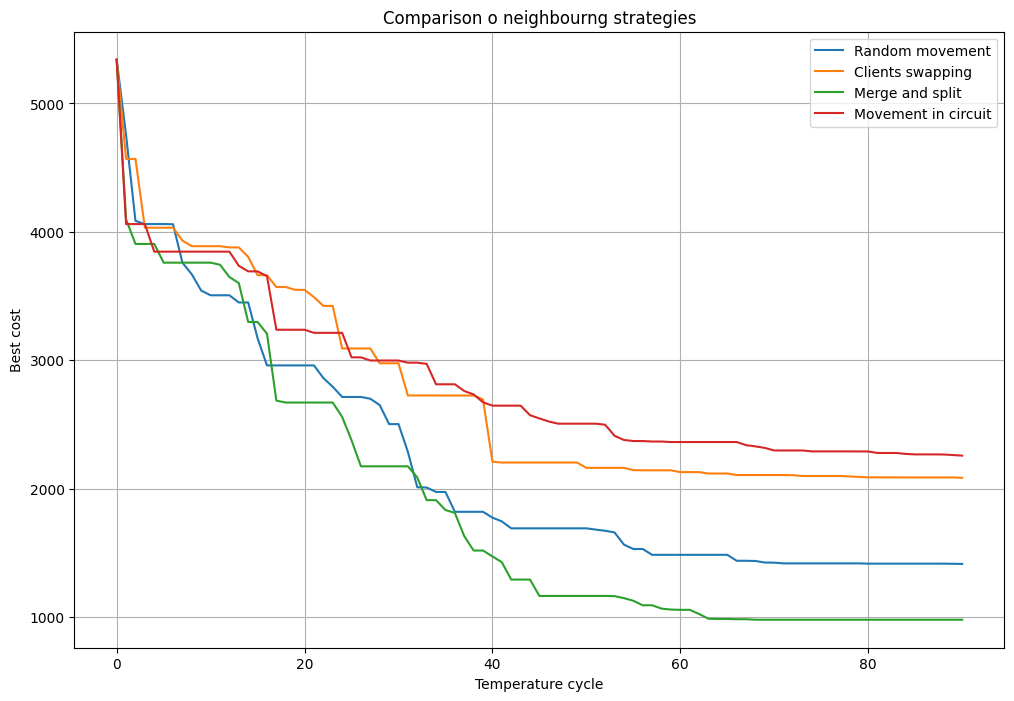

In [ ]:
# Use with the visualization of different strategies
visualiser_strategies(strategies,temperature_initiale=100,iterations_par_cycle=400,facteur_refroidissement=0.95, etat_initial=etat_initial)

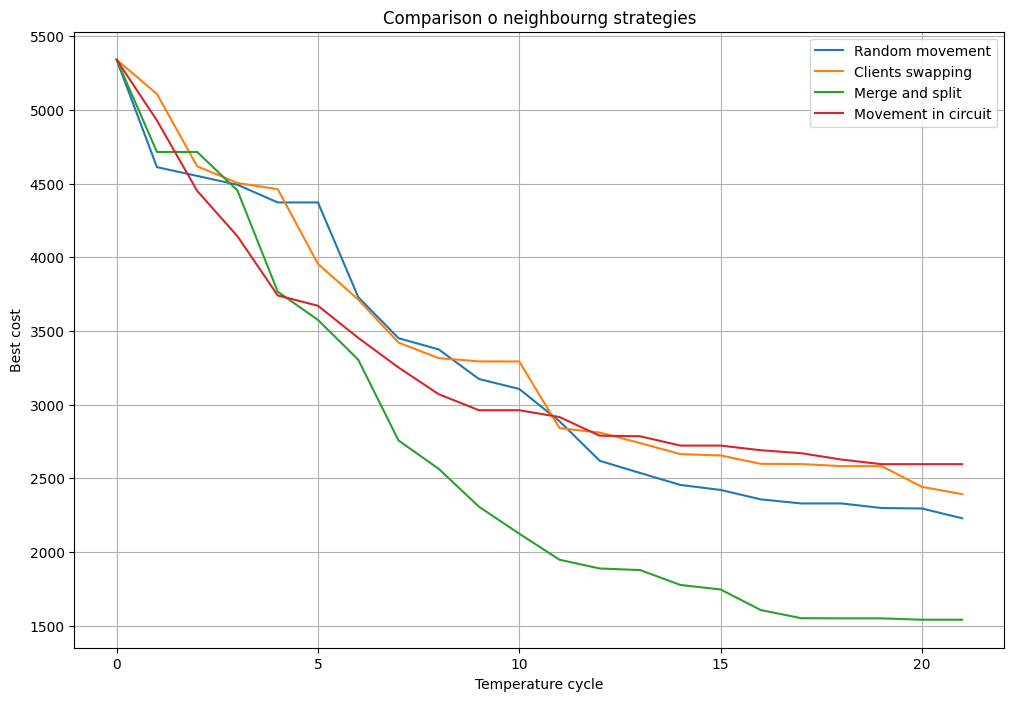

In [ ]:
# Use with the visualization of different strategies
visualiser_strategies(strategies,temperature_initiale=100,iterations_par_cycle=100,facteur_refroidissement=0.8, etat_initial=etat_initial)

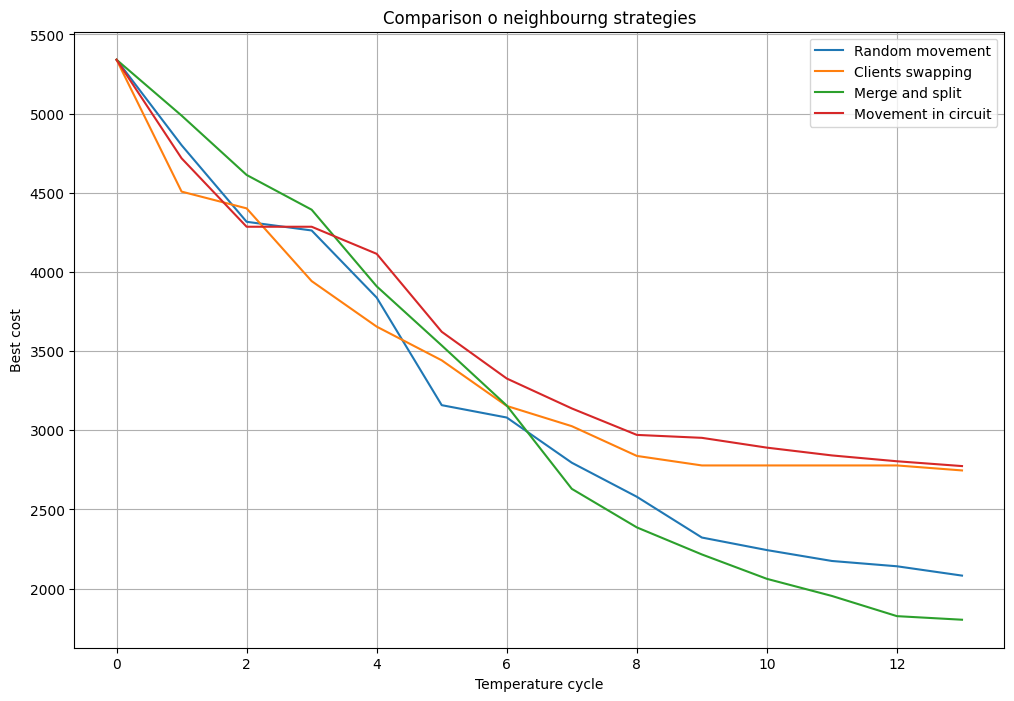

In [ ]:
# Use with the visualization of different strategies
visualiser_strategies(strategies,temperature_initiale=100,iterations_par_cycle=100,facteur_refroidissement=0.7, etat_initial=etat_initial)

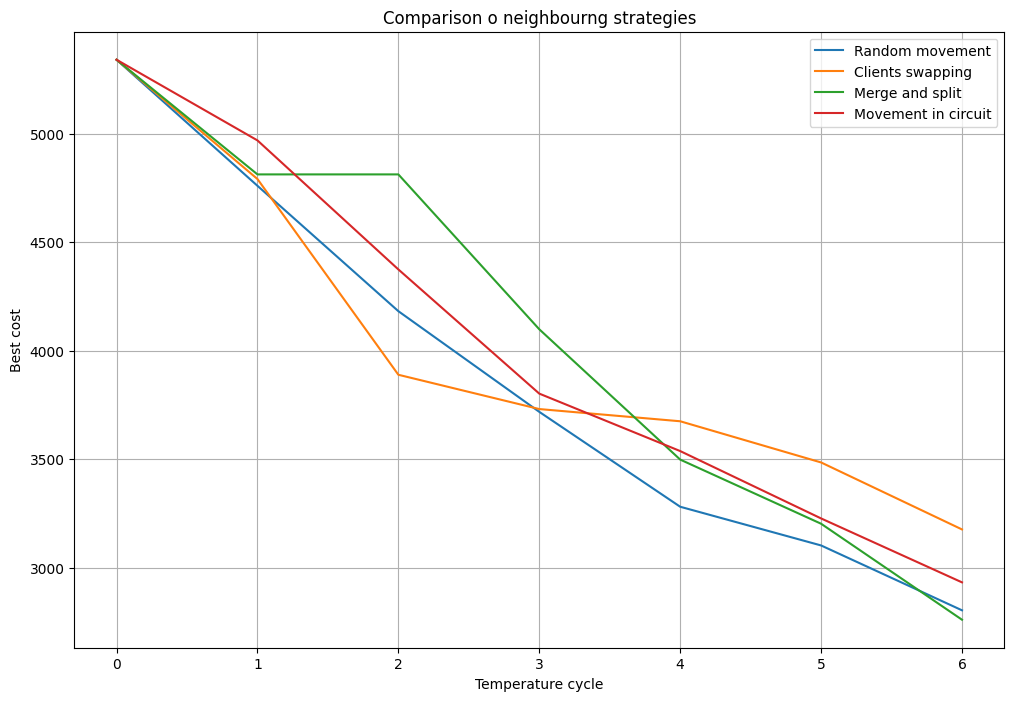

In [ ]:
# Use with the visualization of different strategies
visualiser_strategies(strategies,temperature_initiale=100,iterations_par_cycle=100,facteur_refroidissement=0.4, etat_initial=etat_initial)

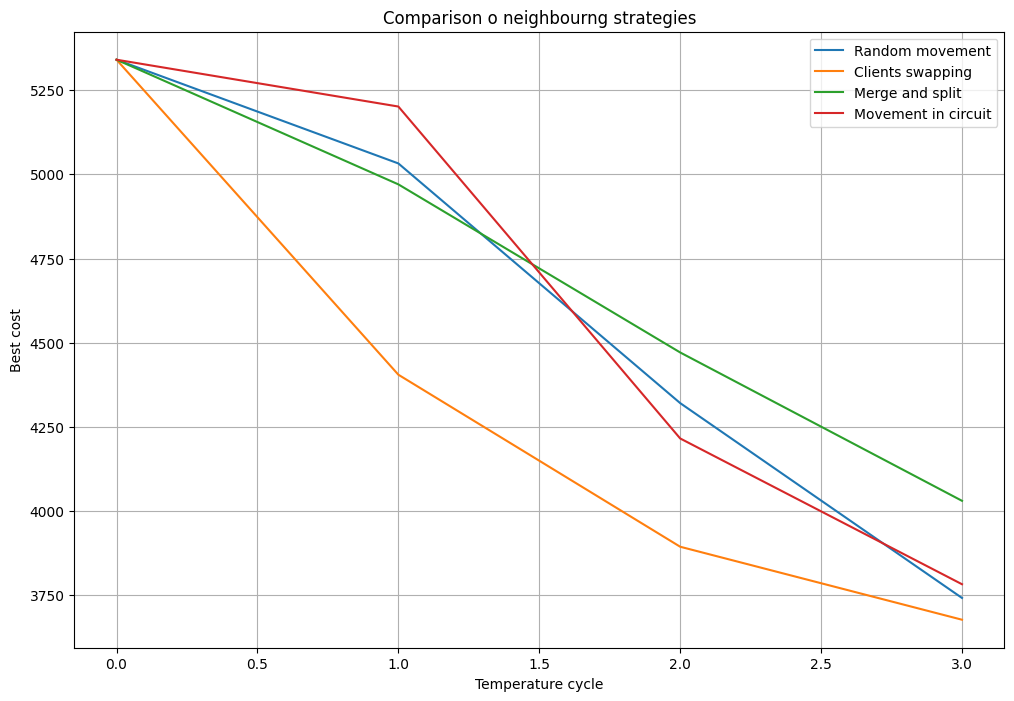

In [ ]:
# Use with the visualization of different strategies
visualiser_strategies(strategies,temperature_initiale=100,iterations_par_cycle=100,facteur_refroidissement=0.2, etat_initial=etat_initial)

# 2) Genetic algorithm part

## 1) Choice of the solutions

In [ ]:
def choose_S(P, energy):
  """
  Choosing half of the schedulings with the best score
  parameters :
  - P : list of schedulings
  - energy : cost function
  return :
  - P_b : list of half of the schedulings with the best score
  """
  P_b = deepcopy(P)
  P_b.sort(key=energy)
  P_b = P_b[0:len(P_b)//2]*2 # selecting only schedulings with best score
  random.shuffle(P_b)
  return P_b

## 2) Crossover of 2 *solutions*

In [ ]:
def croisement(p1, p2, n):
  """
  Crossover of 2 schedulings
  parameters :
  - p1, p2 : schedulings
  - n : number of clients
  return :
  - p1_res, p2_res : schedulings
  """
  p1_tot = []
  p2_tot = []

  i = n+1
  for r in p1:
      p1_tot += r + [i]
      i+=1
  p1_tot.pop()

  i = n+1
  for r in p2:
      p2_tot += r + [i]
      i+=1
  p2_tot.pop()

  d = random.randint(0, len(p1_tot)-2)
  f = random.randint(d+1, len(p1_tot)-1)
  p1_sub = p1_tot[d:f]
  p2_sub = p2_tot[d:f]

  p2_tot_b = deepcopy(p2_tot)
  p1_tot_b = deepcopy(p1_tot)

  for e in range(len(p1_sub)):
      if (not p1_sub[e] in p2_sub ) and (not p2_sub[e] in p1_sub):
          i_e = p2_tot.index(p1_sub[e])
          p2_tot_b[i_e] = p2_sub[e]
  for e in range(len(p2_sub)):
      if (not p2_sub[e] in p1_sub) and (not p1_sub[e] in p2_sub):
          i_e = p1_tot.index(p2_sub[e])
          p1_tot_b[i_e] = p1_sub[e]

  for j in range(d,f):
      if (not p1_sub[j-d] in p2_sub ) and (not p2_sub[j-d] in p1_sub):
          p2_tot_b[j] = p1_sub[j-d]
          p1_tot_b[j] = p2_sub[j-d]

  #print(p1_tot_b, p2_tot_b, p1_sub, p2_sub)

  i_1 = [-1]
  i_2 = [-1]
  for k in range(n+1, i-1):
      k_1 = p1_tot_b.index(k)
      i_1.append(k_1)
      k_2 = p2_tot_b.index(k)
      i_2.append(k_2)
  i_1.sort()
  i_2.sort()
  #print(i_1, i_2)

  p1_res = []
  p2_res = []
  for k_b in range(len(i_1)-1):
      #print(p1_tot_b[i_1[k_b]+1:i_1[k_b+1]])
      p1_res.append(p1_tot_b[i_1[k_b]+1:i_1[k_b+1]])
      p2_res.append(p2_tot_b[i_2[k_b]+1:i_2[k_b+1]])
  #print(p1_tot_b[i_1[k_b+1]+1:])
  p1_res.append(p1_tot_b[i_1[k_b+1]+1:])
  p2_res.append(p2_tot_b[i_2[k_b+1]+1:])

  return(p1_res, p2_res)

## 3) Mutation function

In [ ]:
def mutation(p, n):
  """
  Swap the place of 2 random clients in a scheduling
  parameters :
  - p : scheduling
  - n : number of clients
  return :
  - p_res : schedule
  """
  p_tot = []

  i = n+1
  for r in p:
      p_tot += r + [i]
      i+=1
  p_tot.pop()

  d = random.randint(0, len(p_tot)-2)
  f = random.randint(d+1, len(p_tot)-1)

  for k in range((f-d)//2):
      p_tot[d+k], p_tot[f-k] = p_tot[f-k], p_tot[d+k]

  i_1 = [-1]
  for k in range(n+1, i-1):
      k_1 = p_tot.index(k)
      i_1.append(k_1)

  i_1.sort()
  p_res = []
  for k_b in range(len(i_1)-1):
      #print(p1_tot_b[i_1[k_b]+1:i_1[k_b+1]])
      p_res.append(p_tot[i_1[k_b]+1:i_1[k_b+1]])
  #print(p1_tot_b[i_1[k_b+1]+1:])
  p_res.append(p_tot[i_1[k_b+1]+1:])

  return(p_res)

## 4) Genetic algorithm

In [ ]:
def impl_ordo_gen(nb_gen = 100, nb_iter = 500, f_cout=calcul_cout, P_cross = 0.7, P_mut = 0.1):
  """
  Scheduling of roads taking into account weight and volume constraints
  parameters :
  - nb_gen : number of genes (default : 100)
  - nb_iter : number of iteration (default : 500)
  - f_cout : cost function (default : calcul_cout)
  - P_cross : probability of crossover (default : 0.7)
  - P_mut : probability of mutation (default : 0.1)
  return :
  - m_e : best score
  - St_1[m] : best scheduling
  """
  N = nb_gen//2*2
  P = []
  nb_client = len(clients)

  for _ in range(N):
      s = generer_ordonnancement_aleatoire(nb_client, len(vehicules))
      while not ordonnancement_valide_reel(s):
          s = generer_ordonnancement_aleatoire(nb_client, len(vehicules))
      P.append(s)

  meilleure_solution = min(P, key=lambda x: f_cout(x))
  hist_couts = [f_cout(meilleure_solution)]

  St_1 = deepcopy(P)

  for _ in range(nb_iter):
      St = choose_S(St_1, f_cout)
      St_1 = []
      for i in range(N//2):
          if random.random()<P_cross:
              A, B = croisement(St[i*2], St[i*2+1], nb_client)
              #print(A,B)
              #print(is_order_valid(A))
              #print(is_order_valid(B))
              while not ordonnancement_valide_reel(A) or not ordonnancement_valide_reel(B):
                  A, B = croisement(St[i*2], St[i*2+1], nb_client)
              St_1.append(A)
              St_1.append(B)
          else:
              St_1.append(deepcopy(St[i*2]))
              St_1.append(deepcopy(St[i*2+1]))

      for i in range(N):
          if random.random()<P_mut:
              m_i = mutation(St_1[i], nb_client)
              while not ordonnancement_valide_reel(m_i):
                  m_i = mutation(St_1[i], nb_client)
              St_1[i] = m_i
      meilleure_solution = min(St_1, key=lambda x: f_cout(x))
      hist_couts.append(f_cout(meilleure_solution))

  historique = []
  m = 0
  m_e = f_cout(St_1[0])
  for k in range(1,nb_gen):
      e = f_cout(St_1[k])
      historique.append(e)
      if e<m_e:
          m=k
          m_e=e
  #plt.plot(historique)
  plt.plot(hist_couts)
  plt.xlabel('Number of iterations')
  plt.ylabel('Best cost')
  plt.grid(True)

  return m_e, St_1[m]


In [ ]:
def gen_init(nb_gen):
  """
  Create a list of random schedulings
  parameter :
  - nb_gen : number of schedulings to create
  return :
  - P : list of random schedulings
  """
  N = nb_gen//2*2
  P = [] #N individus

  nb_client = len(clients)

  for _ in range(N):
      s = generer_ordonnancement_aleatoire_valide(nb_client, len(vehicules))
      while not ordonnancement_valide_reel(s):
          s = generer_ordonnancement_aleatoire_valide(nb_client, len(vehicules))
      P.append(s)
  return P

def ordo_gen_SMA(gen, nb_iter = 500, f_cout=calcul_cout, P_cross = 0.7, P_mut = 0.1):
  """
  Scheduling of roads taking into account weight and volume constraints.
  This algorithm is suitable for use in multi-agent systems.
  parameters :
  - gen : schedulings
  - nb_iter : number of iteration (default : 500)
  - f_cout : cost function (default : calcul_cout)
  - P_cross : probability of crossover (default : 0.7)
  - P_mut : probability of mutation (default : 0.1)
  return :
  - m_e : best score
  - St_1[m] : best scheduling
  """
  N = len(gen)//2*2
  P = gen

  nb_client = len(clients)

  St_1 = deepcopy(P)

  for _ in range(nb_iter):
      St = choose_S(St_1, f_cout)
      St_1 = []
      for i in range(N//2):
          if random.random()<P_cross:
              A, B = croisement(St[i*2], St[i*2+1], nb_client)
              #print(A,B)
              #print(is_order_valid(A))
              #print(is_order_valid(B))
              while not ordonnancement_valide_reel(A) or not ordonnancement_valide_reel(B):
                  A, B = croisement(St[i*2], St[i*2+1], nb_client)
              St_1.append(A)
              St_1.append(B)
          else:
              St_1.append(deepcopy(St[i*2]))
              St_1.append(deepcopy(St[i*2+1]))

      for i in range(N):
          if random.random()<P_mut:
              m_i = mutation(St_1[i], nb_client)
              while not ordonnancement_valide_reel(m_i):
                  m_i = mutation(St_1[i], nb_client)
              St_1[i] = m_i
  historique = []
  m = 0
  m_e = f_cout(St_1[0])
  for k in range(1,len(gen)):
      e = f_cout(St_1[k])
      historique.append(e)
      if e<m_e:
          m=k
          m_e=e
  plt.plot(historique)
  plt.ylabel('Cost')
  plt.xlabel('Schedulings of the last generation')
  plt.grid(True)

  return m_e, St_1[m]

[[41, 36, 16, 18, 54, 69, 24, 27], [97, 66, 29, 43, 105, 91, 21, 103, 99, 46, 1, 88, 11, 75, 4], [90, 79, 81, 59, 55, 22, 76, 33, 77, 74, 67, 7, 56, 84], [6, 96, 65, 37, 48, 9, 57, 38, 72, 12, 28, 17, 73, 45, 10, 52, 87, 47, 94, 19, 58, 80, 101, 71, 85, 104], [49, 89, 61, 40, 60, 68, 98, 8, 23, 102, 86, 26, 100, 34, 107, 31, 64, 51, 53, 92, 95, 30, 39, 83, 25, 20, 93], [], [], [14, 62, 5, 42, 2, 82, 70, 63, 44, 3, 50, 35, 106, 78, 15, 13, 32]]
2273.094874902371


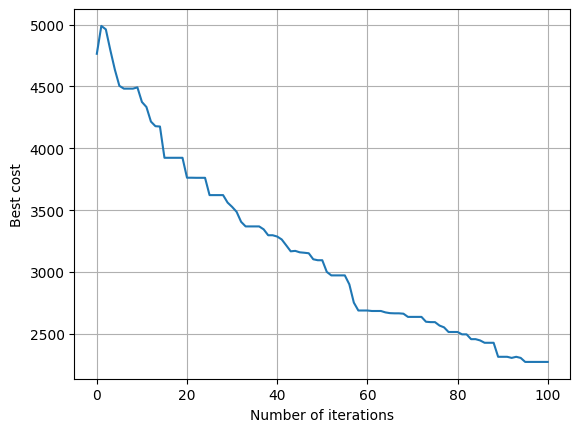

In [ ]:
o = impl_ordo_gen(nb_gen=100, nb_iter = 100, f_cout=calcul_cout, P_cross=0.7, P_mut=0.1)
print(o[1])
print(o[0])

[[14], [], [45, 56, 75, 31, 32, 22, 51, 92, 64, 6, 15, 12, 83, 19, 71, 42, 58, 69, 7, 41, 70, 55, 103, 2, 81, 99, 54, 17, 59, 66, 48, 10, 37, 38, 82, 46, 98, 68, 93, 35, 30, 53, 26, 100, 11, 4, 8, 88, 106, 47, 97], [], [79, 63, 60, 27, 33, 13, 34, 76, 95, 105, 78, 102, 87, 96, 104, 23, 3, 77, 52], [], [90, 86, 1, 101, 67, 16, 65, 20, 94, 73, 62, 9, 24], [29, 107, 43, 74, 50, 39, 80, 25, 18, 61, 5, 57, 89, 44, 28, 72, 21, 40, 49, 91, 36, 84, 85]]
1603.0560703677584


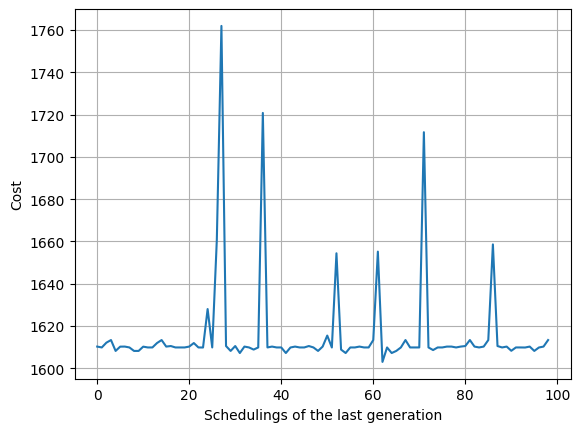

In [ ]:
o2 = ordo_gen_SMA(gen = gen_init(100), nb_iter = 200, f_cout=calcul_cout, P_cross=0.7, P_mut=0.1)
print(o2[1])
print(o2[0])

#3) Tabu algorithm part

Remarque : Cette fonction donne un temps de route cohérent mais ne tiens pas compte des ralentissements


### 1) Data choice

In [ ]:
# Selects clients from the first route (ID : 2946091) to test the algorithm on them

data_test = clients
data_test = data_test.drop(["ROUTE_ID","CUSTOMER_TIME_WINDOW_FROM_MIN", "CUSTOMER_TIME_WINDOW_TO_MIN", "NUMBER_OF_ARTICLES", "TOTAL_WEIGHT_KG", "TOTAL_VOLUME_M3"], axis=1)

###2) List algorithm

In [ ]:
# list scheduling for 1 vehicle

def algoListeSimple(NbClients, NbVoitures, depot, df):
  """

  parameters :
  - NbClients : restriction of the number of clients considered for the test
  - NbVoitures = number of vehicles
  - depot : coordinates of the warehouse
  - df : DataFrame of the clients
  return :
  ordonnancement : scheduling
  """
  dist_parcourue=[] # List of the distances traveled by each lorry
  ordonnancement=[]
  df=df.head(NbClients) # Takes the first clients of the DataFrame


  position_voitures=[]
  for i in range(0, NbVoitures):
    position_voitures.append(depot)

  data=df.to_dict(orient='index')
  clients=list(data)

  # Lorries start from the warehouse
  for i in range(0, NbVoitures):
    dist_parcourue.append(0)
    ordonnancement.append([0])

  while len(clients)!=0:
    # Chooses the lorry with the least distance traveled
    d = min(dist_parcourue)
    voitureDispo = dist_parcourue.index(d)
    last_loc = position_voitures[voitureDispo]

    # Chooses a priority client
    clientNb = client_prio(data, last_loc, clients)

    # Compute the total distance traveled by a lorry
    clientCoord = [data[clientNb]["CUSTOMER_LATITUDE"], data[clientNb]["CUSTOMER_LONGITUDE"]]
    distance = haversine(last_loc[0], last_loc[1], clientCoord[0], clientCoord[1])
    dist_parcourue[voitureDispo]+=distance

    # The customer is added to the vehicle's route and its location is updated
    ordonnancement[voitureDispo].append(data[clientNb]["CUSTOMER_NUMBER"])
    clients.remove(clientNb)
    position_voitures[voitureDispo] = clientCoord

  # Lorries come back to the warehouse at the end of their route
  for i in range(0, NbVoitures):
    ordonnancement[i].append(0)

  return ordonnancement

def client_prio(data, last_loc, clients):
  """

  parameters :
  - data :
  - last_loc : coordinates of the vehicle
  - clients :
  return :
  - closestClient : client
  """
  # The closest customer to the lorry with coordinates last_loc is chosen
  closestClient=clients[0]
  client0coord = [data[closestClient]["CUSTOMER_LATITUDE"], data[closestClient]["CUSTOMER_LONGITUDE"] ]
  distMin=haversine(last_loc[0], last_loc[1], client0coord[0], client0coord[1])
  for i in clients[1:]:
    clientCoord = [ data[i]["CUSTOMER_LATITUDE"], data[i]["CUSTOMER_LONGITUDE"] ]
    distance = haversine(last_loc[0], last_loc[1], clientCoord[0], clientCoord[1])
    if distance<distMin:
      distMin = distance
      closestClient = i
  return closestClient

In [ ]:
depot = [43.37392833, 17.60171712]
ordo_liste=algoListeSimple(100, 8, depot, data_test)
print(ordo_liste)

[[0, 79, 16, 71, 80, 66, 58, 57, 42, 70, 41, 5, 87, 26, 0], [0, 86, 69, 7, 20, 10, 81, 35, 33, 31, 0], [0, 90, 9, 83, 98, 93, 1, 61, 23, 4, 0], [0, 97, 48, 21, 59, 49, 47, 53, 0], [0, 27, 24, 40, 38, 52, 14, 76, 0], [0, 67, 60, 18, 62, 84, 37, 28, 44, 12, 55, 17, 54, 36, 72, 63, 82, 99, 78, 92, 0], [0, 25, 56, 65, 19, 73, 89, 91, 3, 88, 39, 15, 50, 6, 77, 74, 29, 75, 22, 11, 13, 43, 34, 0], [0, 46, 45, 94, 85, 68, 2, 96, 8, 64, 100, 95, 30, 32, 51, 0]]


In [ ]:
def ordo_to_dataset(ordo, data, depot):
  """
  reconstruct the dataset from a scheduling.
  parameters :
  - ordo : a scheduling
  - data :
  - depot : coordinates of the warehouse
  return :
  - df :

  """
  df=[]
  for i in range(len(ordo)):
    d=0
    last_loc=depot
    for client in ordo[i]:
      if client==0:
        clientCoord = depot
      else:
        clientCoord = [data.loc[data['CUSTOMER_NUMBER']==client, 'CUSTOMER_LATITUDE'].iloc[0], data.loc[data['CUSTOMER_NUMBER']==client, 'CUSTOMER_LONGITUDE'].iloc[0]]
      r1 = haversine(last_loc[0], last_loc[1], clientCoord[0], clientCoord[1])
      d_livraison = d + r1
      distance_parcourue = r1
      df.append({
            'Type': client,
            'Start': d,
            'End': d_livraison,
            'Task': i,
            'CUSTOMER_LATITUDE':clientCoord[0],
            'CUSTOMER_LONGITUDE':clientCoord[1],
            'Distance': r1
            })
      last_loc=clientCoord
      d=d_livraison
  return pd.DataFrame(df)

In [ ]:
ordo_df=ordo_to_dataset(ordo_liste, data_test, depot)
ordo_df

,Type,Start,End,Task,CUSTOMER_LATITUDE,CUSTOMER_LONGITUDE,Distance
0,0,0.000000,0.000000,0,43.373928,17.601717,0.000000
1,79,0.000000,0.299363,0,43.373120,17.605250,0.299363
2,16,0.299363,15.916558,0,43.338410,17.792420,15.617195
3,71,15.916558,16.718059,0,43.339780,17.802150,0.801500
4,80,16.718059,17.419921,0,43.338239,17.810566,0.701863
...,...,...,...,...,...,...,...
111,95,137.850915,138.099775,7,43.715620,17.228940,0.248860
112,30,138.099775,138.385257,7,43.717630,17.226730,0.285481
113,32,138.385257,138.607477,7,43.719590,17.227270,0.222221
114,51,138.607477,139.139526,7,43.723870,17.224310,0.532049


In [ ]:
def showRoute(ordo, df, depot):
  """
  Print in a single plot the roads used by the vehicles.
  parameters :
  - ordo : a scheduling
  - df :
  - depot : coordinates of the warehouse
  return :
  - plot of the roads used by the vehicles
  """
  ordo_df=ordo_to_dataset(ordo, df, depot)
  fig, ax = plt.subplots()

  for i in range(0,8):
    ordo_p=ordo_df[ordo_df['Task']==i]
    ax.plot(ordo_p["CUSTOMER_LONGITUDE"], ordo_p["CUSTOMER_LATITUDE"], label=f"Type {i}")

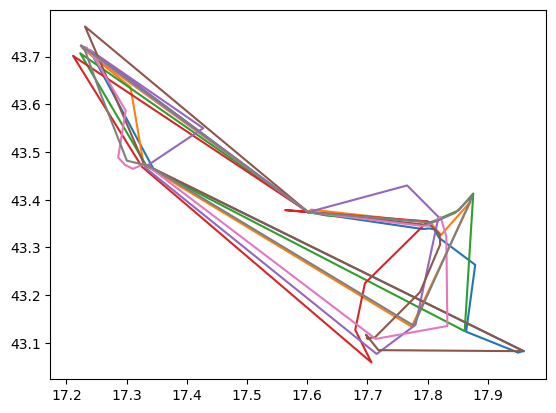

In [ ]:
showRoute(ordo_liste, data_test, depot)

In [ ]:
def showEachRoute(ordo):
  """
  Show the route taken for each of the 8 vehicles for route 1.
  parameter :
  - ordo : a scheduling
  return :
  - 8 plots of the routes of the 8 vehicles for route 1
  """
  ordo_df=ordo_to_dataset(ordo, data_test, depot)
  for i in range(8):
    ordo_voiture_i=ordo_df[ordo_df['Task']==i]
    latitude = ordo_voiture_i['CUSTOMER_LATITUDE'].tolist()
    longitude = ordo_voiture_i['CUSTOMER_LONGITUDE'].tolist()
    customer_codes = ordo_voiture_i['Type'].tolist()

    # Creates the plot
    plt.figure(figsize=(10, 6))

    # Adds the client code to each visited position
    for i in range(len(latitude)):
      top_or_bot = (-1)**i
      plt.annotate(customer_codes[i], (longitude[i], latitude[i]), textcoords="offset points", xytext=(0,top_or_bot*10), ha='center', fontsize=6)

    # Construction of the plots
    plt.scatter(longitude, latitude, color='blue')
    for i in range(len(latitude)-1):
      plt.plot([longitude[i], longitude[i+1]], [latitude[i], latitude[i+1]], color='red')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Customer Locations')
    plt.grid(True)
    plt.show()

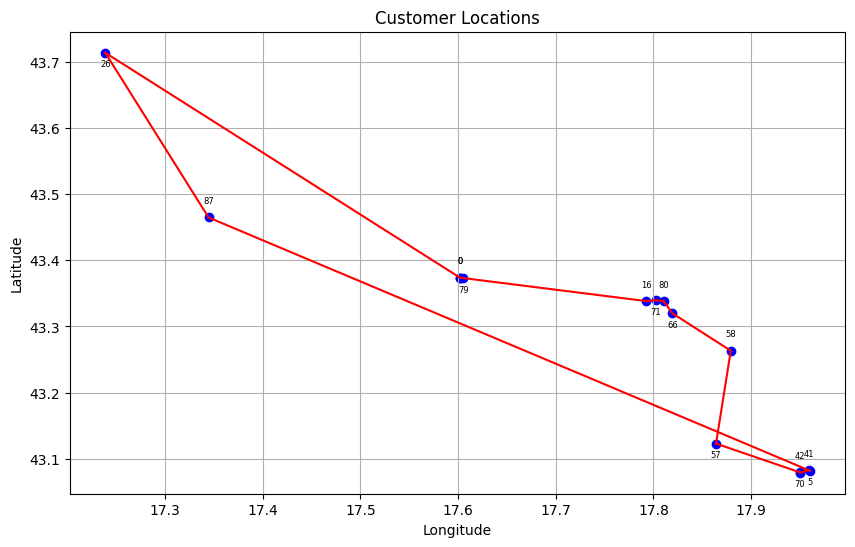

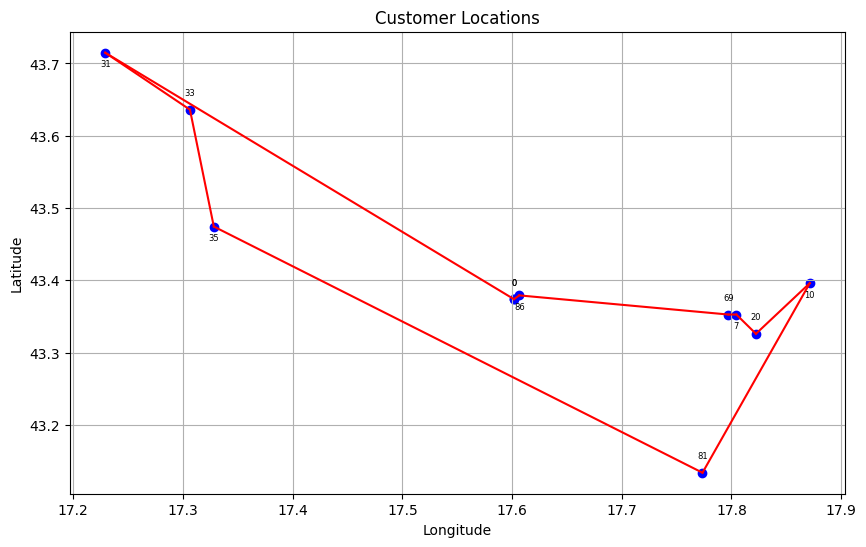

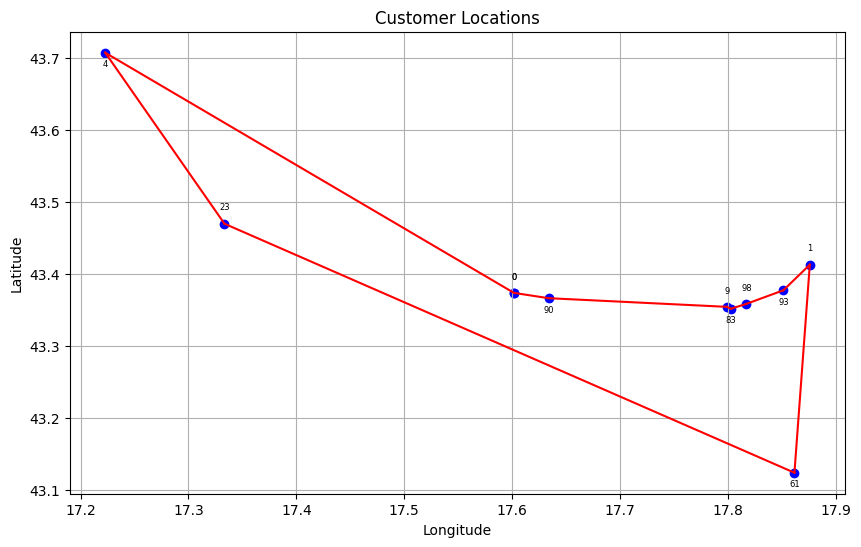

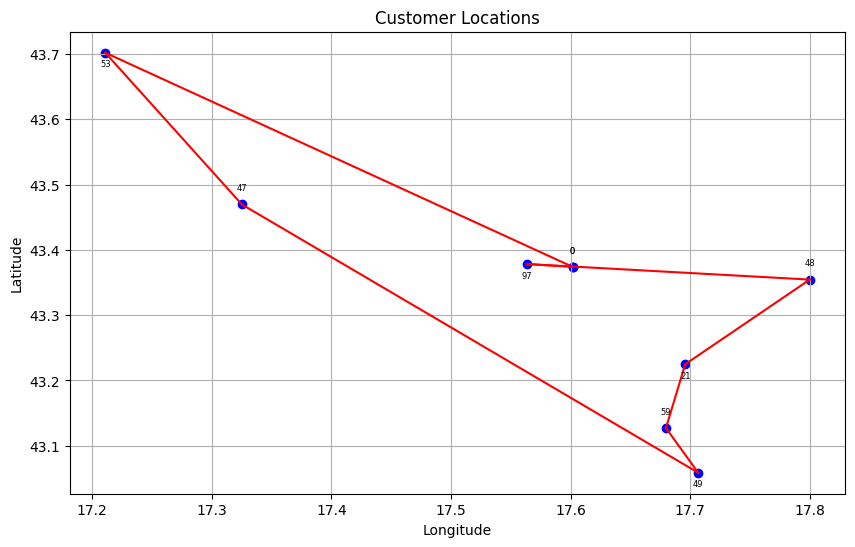

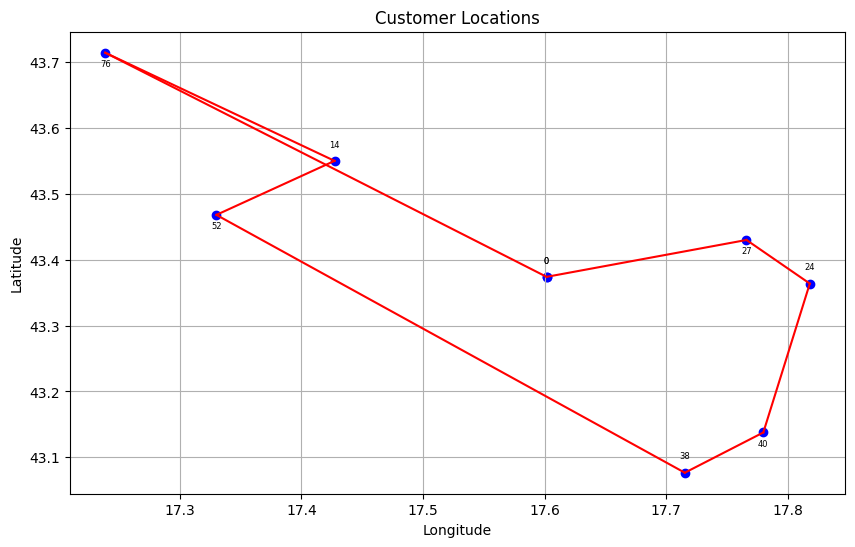

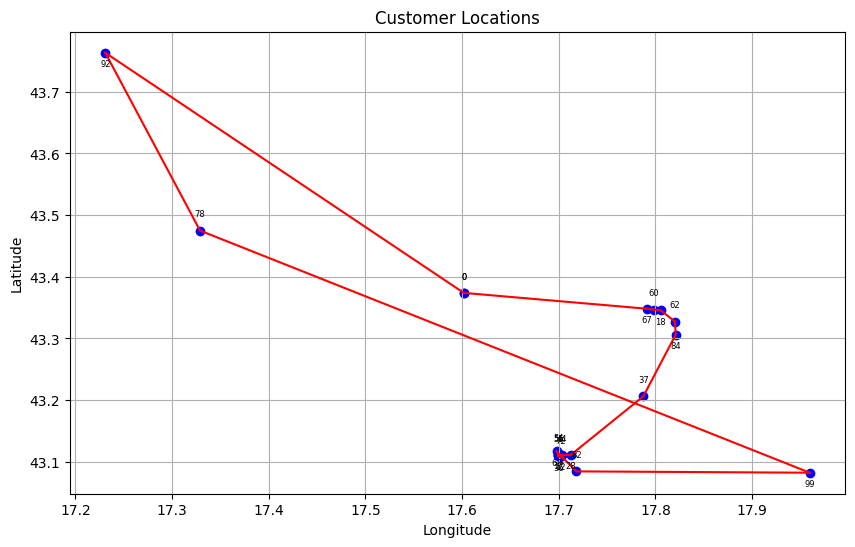

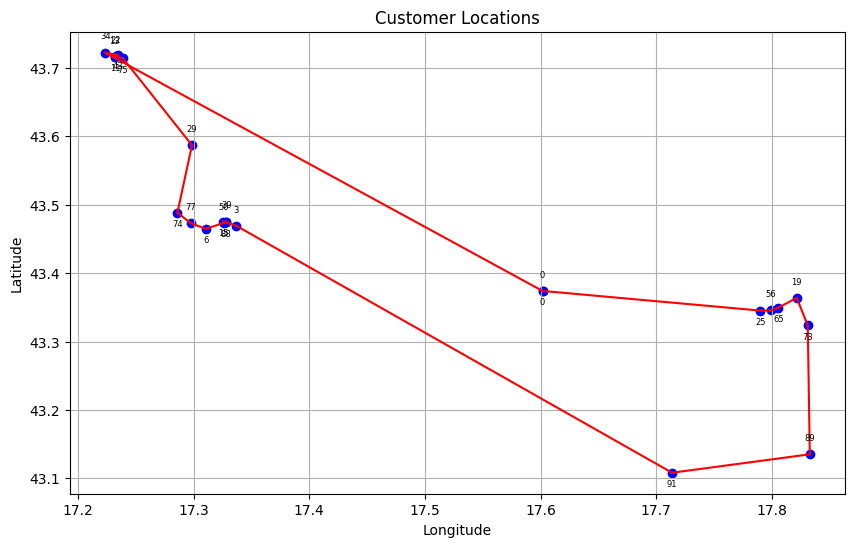

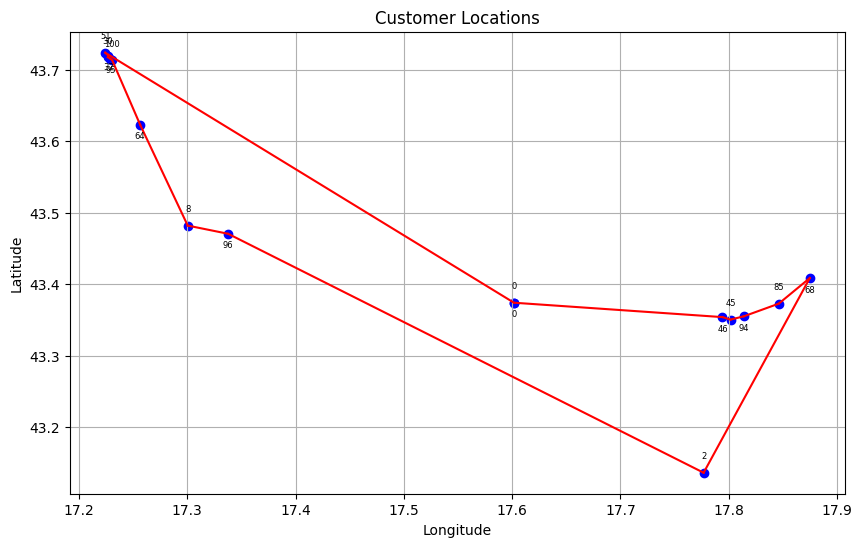

In [ ]:
showEachRoute(ordo_liste)

In [ ]:
calcul_cout(ordo_liste)

2183.059938919443

###3) Tabu search algorithm

In [ ]:
def ordo_to_tab_list(ordo):
  """
  transforms the list of lists of visited positions for each car into
  A single list where the different vehicles are separated by -1s.
  This makes it easier to construct neighboring lists in the taboo scheduling algorithm.
  parameter :
  - ordo : a scheduling
  return :
  - tabç_list : a scheduling in the format of a list
  """
  tab_list=[]
  for voiture in ordo:
    for code in voiture:
      tab_list.append(code)
    tab_list.append(-1)
  tab_list.pop() # On enlève le dernier -1
  return tab_list

def tab_list_to_ordo(tab_list):
  """
  Transforms the format list for taboo search into a classic scheduling list of lists.
  parameter :
  - tab_list : a scheduling in the format of a list
  return :
  - ordo : a scheduling

  """
  ordo=[[]]
  for i in tab_list:
    if i==-1:
      ordo.append([])
    else:
      ordo[-1].append(i)
  return ordo

In [ ]:
def algoTabou(s_depart, NbIterMax, Nbvoisins, Historique_scores):
  """

  parameters :
  - s_depart : a scheduling
  - NbIterMax : maximum number of iterations
  - Nbvoisins : number of neighboors
  - Historique_scores : empty list
  return :
  - tab_list_to_ordo(s_star) :
  """
  s_avec_0 = ordo_to_tab_list(s_depart)
  s = [x for x in s_avec_0 if x != 0] # Removes movements to the warehouse
  s_star=s
  nb_iter=0
  T=[]
  meil_score = calcul_cout(tab_list_to_ordo(s_star))
  while (nb_iter<NbIterMax):
    nb_iter+=1
    # Creates neighbours and chooses the best
    V=voisins(s, Nbvoisins)
    v,M=choixVoisin(V,T)
    if(M<meil_score):
      # If the score of the best neighbours is inferior to the current record, we keep it
      s_star=v
      meil_score=M
      s=v
      #print("improvement : " +str(meil_score))
    else:
      # Otherwise, we add it to the tabu list
      T.append(v)
      #if len(T)>10:
      #  del T[0]
      #print(len(T))
      s=v
    Historique_scores.append(meil_score)
  return tab_list_to_ordo(s_star)

def voisins(sol, NbVoisins):
  """
  # Récupère tous les ordonnancements voisins d'un ordonnancement (à une permutation près)

  """
  V=[]
  # Méthod 1 : Swapping randomly 2 clients
  for i in range(NbVoisins):
    a,b=random.randint(0,len(sol)-1), random.randint(0,len(sol)-1)
    v=copy.deepcopy(sol)
    v[a],v[b]=v[b],v[a]
    # checks the criterias of volume and weight
    if(ordonnancement_valide_reel(tab_list_to_ordo(v))):
      V.append(v)

  # Méthod 2 : inversing a part of the list
  for i in range(NbVoisins):
    a,b=random.randint(0,len(sol)-1), random.randint(0,len(sol)-1)
    v=copy.deepcopy(sol)
    v[a:b]= reversed(v[a:b])
    # checks the criterias of volume and weight
    if(ordonnancement_valide_reel(tab_list_to_ordo(v))):
      V.append(v)

  # Method 3 : Moving a part of the list
  for i in range(NbVoisins):
    a,b=random.randint(0,len(sol)-1), random.randint(0,len(sol)-1)
    v=copy.deepcopy(sol)
    if b<a:
      a,b=b,a
    seq=v[a:b]
    del v[a:b]
    c=random.randint(0,len(v))
    v = v[0:c] + seq + v[c:len(v)]
    # checks the criterias of volume and weight
    if(ordonnancement_valide_reel(tab_list_to_ordo(v))):
      V.append(v)

  if(len(V)==0):
    print("No neighbour found!")
  return V


def choixVoisin(V,T):
  """
  # On choisit le voisin qui minimise le score
  # On commence par choisir un voisin qui n'est pas dans T
  prameters :
  - v :
  - T :
  return :
  - V[MeilleurVoisin] : Best scheduling
  - MeilleurScore : score of the best scheduling
  """
  init=0
  while (V[init] in T):
    init+=1
  MeilleurVoisin=init
  MeilleurScore=calcul_cout(tab_list_to_ordo(V[init]))
  for k in range(0,len(V)):
    Score=calcul_cout(tab_list_to_ordo(V[k]))
    if (Score<MeilleurScore and not(V[k] in T)):
      MeilleurVoisin=k
      MeilleurScore=Score
  return V[MeilleurVoisin], MeilleurScore


In [ ]:
Historique_scores=[]
s_depart = o2[1]

calcul_cout(s_depart)

1603.0560703677584

[[], [], [86, 46, 69, 67, 25, 16, 56, 18, 65, 45, 7, 83, 48, 24, 98, 94, 71, 80, 101, 62, 20, 66, 73, 58, 5, 99, 41, 70, 42, 57, 61, 89, 2, 81, 40, 37, 84], [104, 102, 87, 96, 39, 78, 88, 6, 77, 74, 29, 64, 4, 100, 76, 30, 32, 34, 51, 92, 22, 11, 95, 43, 75, 26, 107, 13, 105, 31, 53, 33, 14, 27, 1, 68, 10, 93, 85, 19, 9, 60, 79], [], [97, 3, 23, 52, 47, 106, 8, 50, 15, 35], [], [90, 21, 28, 91, 82, 38, 49, 72, 103, 44, 12, 36, 55, 17, 54, 63, 59]]
492.48595046024775
True


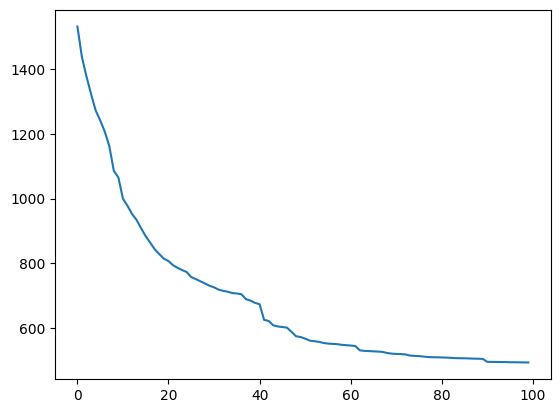

In [ ]:
Historique_scores=[]
solution_tabou = algoTabou(s_depart, 100, 400, Historique_scores)
print(solution_tabou)
print(calcul_cout(solution_tabou))
print(ordonnancement_valide_reel(solution_tabou))
plt.plot(Historique_scores)

# 4) SMA

## 1) Diversity

In [ ]:
def arcs_from_routes(routes):
    """Convert a list of routes into a set of arcs."""
    arcs = set()
    for route in routes:
        # Add arc from depot to first client, and from last client to depot
        if route:
            arcs.add((0, route[0]))
            arcs.add((route[-1], 0))

        # Add arcs between consecutive clients
        for i in range(len(route) - 1):
            arcs.add((route[i], route[i+1]))

    return arcs

def compare_schedules(schedule1, schedule2):
    """Compare two schedules and return the number of different arcs."""
    # Convert each schedule into a set of arcs
    arcs1 = arcs_from_routes(schedule1)
    arcs2 = arcs_from_routes(schedule2)

    # Calculate the symmetric difference between the two sets of arcs
    different_arcs = arcs1.symmetric_difference(arcs2)

    return len(different_arcs)

# Test function with two example schedules
schedule_a = [[86, 14, 78, 79], [46, 83, 45]]
schedule_b = [[86, 14, 79], [46, 83, 45, 69]]

compare_schedules(schedule_a, schedule_b)


6

In [ ]:
!pip install mesa


In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation

##2) Agent class

In [ ]:
from mesa.time import StagedActivation

class RecuitAgent(Agent):
    """ Definition of the agent class of the simulated annealing metaheuristic """
    def __init__(self, unique_id, model, temperature_initiale, iterations_par_cycle, facteur_refroidissement, etat_initial, strategie_voisin):
        super().__init__(unique_id, model)
        # Set the initial parameters of the annealing process
        self.temperature_initiale = temperature_initiale
        self.iterations_par_cycle = iterations_par_cycle
        self.facteur_refroidissement = facteur_refroidissement
        self.etat_initial = etat_initial
        self.strategie_voisin = strategie_voisin

    def step(self):
        # Execute the simulated annealing process and store the result (best_score, best_sol)
        self.res = self.model.ordo_recuit(self.temperature_initiale, self.iterations_par_cycle, self.facteur_refroidissement, self.etat_initial, self.strategie_voisin)
        # Append the result to the model's results list
        self.model.results.append((self.res[0], self.res[1]))
        # Update the best score found so far in the model
        self.model.update_best_score(self.res[0], self.res[1])



class TabouAgent(Agent):
    """ Definition of the agent class of the taboo metaheuristic """
    def __init__(self, unique_id, model, etat_initial, NbIterMax, Nbvoisins, Historique_scores):
        super().__init__(unique_id, model)
        # Set the initial parameters of the taboo process
        self.etat_initial = etat_initial
        self.NbIterMax = NbIterMax
        self.Nbvoisins = Nbvoisins
        self.Historique_scores = Historique_scores

    def step(self):
        # Execute the simulated annealing process and store the result (best_score, best_sol)
        self.res = self.model.ordo_tabou(self.etat_initial, self.NbIterMax, self.Nbvoisins, self.Historique_scores)
        # Append the result to the model's results list
        self.model.results.append((self.res[0], self.res[1]))
        # Update the best score found so far in the model
        self.model.update_best_score(self.res[0], self.res[1])

class GenAgent(Agent):
    """ Definition of the agent class of the genetics metaheuristic """
    def __init__(self, unique_id, model, gen, nb_iter, P_cross, P_mut):
        super().__init__(unique_id, model)
        # Set the initial parameters of the taboo process
        self.gen = gen  # Initial population
        self.nb_iter = nb_iter
        self.P_cross = P_cross
        self.P_mut = P_mut

    def step(self):
        # Execute the simulated annealing process and store the result (best_score, best_sol)
        self.res = self.model.ordo_gen(self.gen, self.nb_iter, self.P_cross, self.P_mut)
        # Append the result to the model's results list
        self.model.results.append((self.res[0], self.res[1]))
        # Update the best score found so far in the model
        self.model.update_best_score(self.res[0], self.res[1])


## 3) Friend Model

In [ ]:
import random

class OptimizationModel(Model):
    def __init__(self, nb_recuit, nb_tabou, nb_gen, calcul_cout):
        super().__init__()
        # Staged activation allows agents to act in a specific order
        self.schedule = StagedActivation(self, stage_list=["step"])
        # Store results of optimizations
        self.results = []
        # Track the best score encountered, initialized to infinity
        self.best_score = float('inf')
        # Store the best solution found
        self.best_sol = None
        # Function to calculate the cost of a solution
        self.calcul_cout = calcul_cout
        # Initialize the Best performance Set (Pool of solutions)
        self.EMP = []
        # Keep a history of best scores
        self.best_score_history = []

        # Add simulated annealing agents
        for i in range(nb_recuit):
            temperature_initiale = 100
            iterations_par_cycle = 200
            facteur_refroidissement = 0.95
            etat_initial = None
            strategie_voisin = fusionner_diviser_routes
            agent = RecuitAgent(i, self, temperature_initiale, iterations_par_cycle, facteur_refroidissement, etat_initial, strategie_voisin)
            self.schedule.add(agent)

        # Add genetic algorithm agents
        for i in range(nb_recuit, nb_recuit + nb_gen):
            gen = gen_init(100)
            nb_iter = 100
            P_cross = 0.7
            P_mut = 0.1
            agent = GenAgent(i, self, gen, nb_iter, P_cross, P_mut)
            self.schedule.add(agent)

        # Add tabu search agents
        for i in range(nb_recuit + nb_gen, nb_recuit + nb_gen + nb_tabou):
            etat_initial = o[1]  # This is a placeholder, ensure it's correctly set
            NbIterMax = 100
            Nbvoisins = 500
            Historique_scores = []
            agent = TabouAgent(i, self, etat_initial, NbIterMax, Nbvoisins, Historique_scores)
            self.schedule.add(agent)

    def ordo_recuit(self, temperature_initiale, iterations_par_cycle, facteur_refroidissement, etat_initial, strategie_voisin):
        # Perform simulated annealing and return the best cost and solution
        meilleur_cout, meilleur_etat, _ = optimiser_ordonnancement(
            temperature_initiale, iterations_par_cycle, facteur_refroidissement,
            self.calcul_cout, etat_initial, strategie_voisin)
        return meilleur_cout, meilleur_etat

    def ordo_gen(self, gen, nb_iter, P_cross, P_mut):
        # Perform genetic algorithm optimization and return score and solution
        score, solution = ordo_gen_SMA(gen, nb_iter, self.calcul_cout, P_cross, P_mut)
        return score, solution

    def ordo_tabou(self, etat_initial, NbIterMax, Nbvoisins, Historique_scores):
        # Perform tabu search and return the best score and solution
        s_star = algoTabou(etat_initial, NbIterMax, Nbvoisins, Historique_scores)
        score = self.calcul_cout(s_star)
        return score, s_star

    def former_EMP(self):
        # Sort results by score to get the best solutions and prepare the Best Performance Set
        meilleurs_scores = sorted(self.results, key=lambda x: x[0])[:len(self.results)//2]

        # Use scheduling comparison to ensure diversity in solutions
        diversite_scores = []
        for i, (score1, sol1) in enumerate(meilleurs_scores):
            for score2, sol2 in meilleurs_scores[i+1:]:
                diversite = compare_schedules(sol1, sol2)
                diversite_scores.append((diversite, sol1, sol2))
        diversite_scores.sort(key=lambda x: x[0])

        # Select solutions with the least diversity to promote convergence
        for _, sol1, sol2 in diversite_scores[:len(diversite_scores)//2]:
            if sol1 not in self.EMP:
                self.EMP.append(sol1)
            if sol2 not in self.EMP and len(self.EMP) < len(meilleurs_scores) // 2:
                self.EMP.append(sol2)

    def update_best_score(self, new_score, solution):
        # Update the model's best score and store the solution if it's the best found
        if new_score < self.best_score:
            self.best_score = new_score
            self.best_sol = solution
            self.best_score_history.append(self.best_score)  # Record the best score
            print("New best score:", self.best_score)

    def step(self):
        # Perform a single step in the simulation, updating the Best Performance Set
        self.schedule.step()
        self.former_EMP()

        # Update agents with solutions from the Best Performance Set or generate new ones
        self.mettre_a_jour_solutions_des_agents()
        return self.best_score

    def mettre_a_jour_solutions_des_agents(self):
      for agent in self.schedule.agents:
        if isinstance(agent, (RecuitAgent, TabouAgent)):
            # Choose between a solution from the Best Performance Set or a new random solution
            if self.EMP: # Check if the Best Performance Set is not empty
                agent.etat_initial = random.choice(self.EMP)
            else:
                # Fallback to a random valid scheduling if EMP is empty
                agent.etat_initial = generer_ordonnancement_aleatoire_valide(len(clients), len(vehicules))
        elif isinstance(agent, GenAgent):
            nouvelle_gen = []
            if self.EMP: # Use the Best Performance Set if it's not empty
                nouvelle_gen.extend(self.EMP)
            # Ensure to fill the generation up to a minimum size
            while len(nouvelle_gen) < 50: # Fill up with random solutions if needed
                nouvelle_gen.append(generer_ordonnancement_aleatoire_valide(len(clients), len(vehicules)))
            agent.gen = nouvelle_gen

Étape 1
New best score: 2129.857014225523
New best score: 1944.599404448474
New best score: 1875.008354320712
New best score: 392.4755254543164
New best score: 378.58618000777074
Étape 2
New best score: 378.23734468029573
New best score: 377.0476644806743
New best score: 345.4284141796123


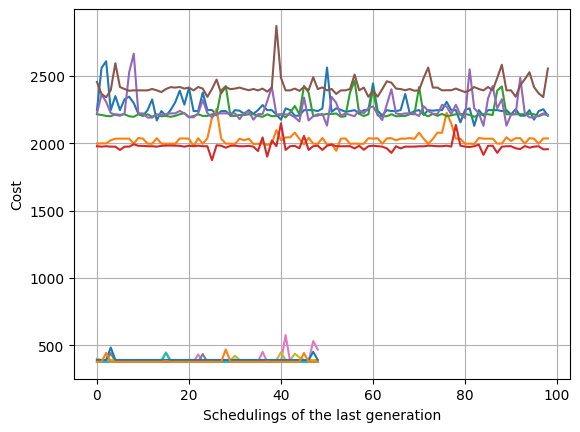

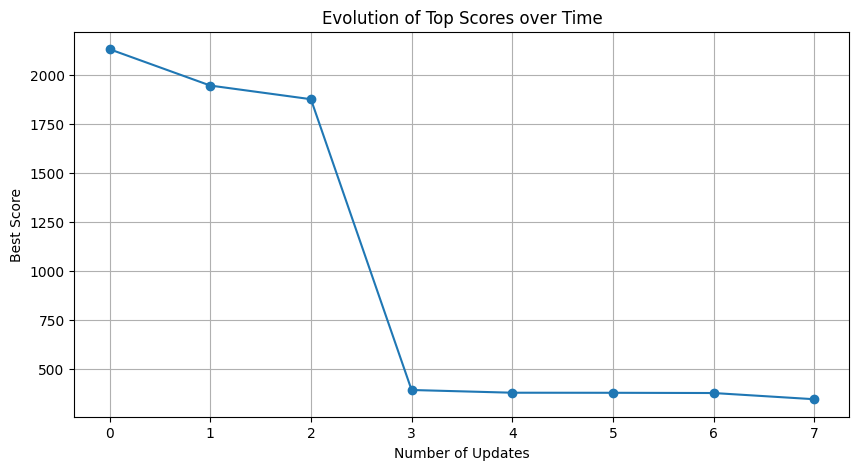

In [ ]:
model = OptimizationModel(nb_recuit=0, nb_tabou=2, nb_gen=6, calcul_cout=calcul_cout)

for i in range(2):  #Example with 5 steps
    print(f"Étape {i+1}")
    model.step()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(model.best_score_history, marker='o', linestyle='-')
plt.title('Evolution of Top Scores over Time')
plt.xlabel('Number of Updates')
plt.ylabel('Best Score')
plt.grid(True)
plt.show()


## 4) Enemy Model


In [ ]:
# Importing libraries

import os.path
import sys
from copy import deepcopy
import numpy as np
import os
import random
import mesa

In [ ]:
import pandas as pd  # Importing Pandas library for data manipulation
from os import listdir  # Importing listdir from os for listing directory contents
from os.path import isfile, join  # Importing isfile and join from os.path for file path manipulation
import numpy as np  # Importing NumPy library for numerical computations
import random  # Importing random module for generating random numbers

from scipy.spatial.distance import pdist, cdist  # Importing functions for computing distances from SciPy

import copy  # Importing copy module for shallow and deep copy operations

import pickle  # Importing pickle module for object serialization
import os  # Importing os module for operating system functionalities
import sys  # Importing sys module for system-specific parameters and functions
import math  # Importing math module for mathematical functions
import itertools  # Importing itertools module for efficient looping and combination generation

##############################################################################################
parent_dir = sys.path[0]  # Setting parent directory as the directory containing the script

# Loading data from CSV files
data_depot = pd.read_csv("/content/data_depot.csv")
data_client_index = pd.read_csv("/content/data_clients.csv")

nombre_client = len(data_client_index)  # Number of clients

# Loading precomputed distance and time matrices from pickle files
with open('/content/Distance.pickle', 'rb') as handle:
    distance_matrix = pickle.load(handle)

with open('/content/Temps.pickle', 'rb') as handle:
    times = pickle.load(handle)

with open('/content/Times.pickle', 'rb') as handle:
    matrice_temps_Cij = pickle.load(handle)

# Extracting data from CSV files into arrays for further calculations
CUSTOMER_DELIVERY_SERVICE_TIME = data_client_index['d'].values
TOTAL_WEIGHT_KG = data_client_index['TOTAL_WEIGHT_KG'].values
CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT = data_depot['TIME_DISTANCE_MIN'].values
CUSTOMER_DELIVERY_SERVICE_DISTANCE_FROM_DEPOT = data_depot['DISTANCE_KM'].values

# Constants for VRP problem
Q = 5000  # Maximum capacity of vehicles
V_moy = 60  # Average speed of vehicles
time_window = 950  # Time limit for delivery
#####################################################################

######################################################################

def get_route(list_client, time_window, Q):
    """
    Generate routes for vehicles based on a list of clients, time window, and vehicle capacity.
    """
    arret = [0]  # Initial stop list with the depot
    i = 0
    while i < len(list_client):
        weight = TOTAL_WEIGHT_KG[list_client[i]]  # Weight of current client
        time = 480 + matrice_temps_Cij[0, list_client[i] + 1]  # Time to go from depot to current client
        while time < time_window and weight < Q:
            i += 1
            if i > len(list_client) - 1:
                break
            time += matrice_temps_Cij[list_client[i - 1] + 1, list_client[i] + 1]
            weight += TOTAL_WEIGHT_KG[list_client[i]]
        arret.append(i)
    Global_route = [list_client[arret[k]:arret[k + 1]] for k in range(len(arret) - 1)]
    return Global_route


#########################################################################################

def Voisinnage(solution_route):
    """
    Generate a neighboring solution by randomly swapping two elements in the route.
    """
    solution = list(itertools.chain.from_iterable(solution_route))
    voisin = solution.copy()
    i = random.randint(0, len(solution) - 1)
    j = random.randint(0, len(solution) - 1)
    voisin[i], voisin[j] = voisin[j], voisin[i]
    return get_route(voisin, time_window, Q)


def recuit_simule(initial_state, temperature_initiale=1.0, temperature_finale=1e-8, alpha=0.99):
    """
    Implement the simulated annealing algorithm to solve the VRP problem.
    """
    current_state = initial_state
    current_energy = cout(current_state)
    best_state = current_state
    best_energy = current_energy
    temperature = temperature_initiale
    beta = abs(1 / (5 * math.log(0.66)))  # Calculate the parameter beta for the Boltzmann distribution
    history_sol = []
    history = []
    while temperature > temperature_finale:
        new_state = Voisinnage(current_state.copy())  # Generate a new neighboring solution
        new_energy = cout(new_state)
        delta_energy = new_energy - current_energy
        if delta_energy < 0 or math.exp(-1 / (beta * temperature)) > random.random():
            current_state = new_state
            current_energy = new_energy
        best_state = current_state
        best_energy = current_energy
        temperature *= alpha
        history.append(best_energy)
        history_sol.append(best_state)
    indice = history.index(min(history))
    return history_sol[indice], history[indice], history


############################################################################################

def selection(Couts, taille_tournoi):
    """
    Select the best element from a tournament among randomly selected elements.
    """
    participants = random.sample(Couts.keys(), taille_tournoi)
    return min(participants, key=lambda x: Couts[x])


def croisement(parent1_route, parent2_route):
    """
    Perform crossover operation on two parent routes to produce offspring routes.
    """
    parent1 = list(itertools.chain.from_iterable(parent1_route))
    parent2 = list(itertools.chain.from_iterable(parent2_route))
    croisement_point = random.randint(1, len(parent1) - 1)
    enfant1 = copy.deepcopy(parent1[:croisement_point]) + copy.deepcopy(parent2[croisement_point:])
    enfant2 = copy.deepcopy(parent2[:croisement_point]) + copy.deepcopy(parent1[croisement_point:])
    enfant_r1 = []
    for element in enfant1:
        if enfant1.count(element) > 1 and element not in enfant_r1:
            enfant_r1.append(element)
    enfant_r2 = []
    for element in enfant2:
        if enfant2.count(element) > 1 and element not in enfant_r2:
            enfant_r2.append(element)
    if len(enfant_r2) != 0:
        for i in range(len(enfant_r2)):
            enfant2[enfant2.index(enfant_r2[i])], enfant1[enfant1.index(enfant_r1[i])] = enfant_r1[i], enfant_r2[i]
    return get_route(enfant1, time_window, Q), get_route(enfant2, time_window, Q)


def mutation(solution_route, taux_mutation):
    """
    Perform mutation operation on a solution route with a given mutation rate.
    """
    solution = list(itertools.chain.from_iterable(solution_route))
    if random.random() < taux_mutation:
        n = len(solution)
        i = np.random.randint(n)
        j = np.random.randint(n)
        solution[j], solution[i] = solution[i], solution[j]
    return get_route(solution, time_window, Q)


def genetique(population, taux_mutation, max_iterations):
    """
    Implement the genetic algorithm to optimize the VRP problem.
    """
    history = []
    taille_population = len(population)
    best_cout = float("inf")
    best_element = None
    for i in range(max_iterations):
        Couts = {k: cout(population[k]) for k in range(taille_population)}
        history.append(min(list(Couts.values())))
        parents = [population[selection(Couts, 2)] for j in range(taille_population)]
        enfants = []
        for ji in range(0, len(parents) - 1, 2):
            enfants1, enfants2 = croisement(parents[ji], parents[ji + 1])
            enfants.append(enfants1)
            enfants.append(enfants2)
        population = [mutation(enfants[j], taux_mutation) for j in range(taille_population)]
        for k in range(taille_population):
            cout_k = cout(population[k])
            if cout_k < best_cout:
                best_cout = cout_k
                best_element = population[k]
    indice = history.index(min(history))
    return best_element, history[indice], history, population


########################################################################################

def voisinage(solution_route):
    """
    Generate a neighboring solution by randomly swapping two elements in the route.
    """
    solution = list(itertools.chain.from_iterable(solution_route))
    voisin = solution.copy()
    i = random.randint(0, len(solution) - 1)
    j = random.randint(0, len(solution) - 1)
    voisin[i], voisin[j] = voisin[j], voisin[i]
    return get_route(voisin, time_window, Q)


def tabou(liste_initiale, taille_tabou, max_iterations, n_voisin):
    """
    Implement the Tabu search algorithm to optimize the VRP problem.
    """
    meilleure_solution = liste_initiale
    meilleure_valeur = cout(meilleure_solution)
    history_sol = [meilleure_solution]
    liste_tabou = []
    history = [meilleure_valeur]
    for i in range(max_iterations):
        for i in range(n_voisin):
            voisin = voisinage(meilleure_solution)
            while voisin in liste_tabou:
                voisin = voisinage(meilleure_solution)
            if i == 0:
                valeur_meilleur_voisin = cout(voisin)
                meilleur_voisin = voisin
            else:
                s = cout(voisin)
                if s < valeur_meilleur_voisin:
                    meilleur_voisin = voisin
                    valeur_meilleur_voisin = s
        meilleure_solution = meilleur_voisin
        meilleure_valeur = valeur_meilleur_voisin
        liste_tabou.append(meilleure_solution)
        if len(liste_tabou) > taille_tabou:
            liste_tabou.pop(0)
        history.append(meilleure_valeur)
        history_sol.append(meilleure_solution)
    indice = history.index(min(history))
    return history_sol[indice], history[indice], history


def position_client(num_client):
    """
    Return the latitude and longitude of a client.
    """
    return positions_clients[num_client]


def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points on the earth (specified in decimal degrees).
    """
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371  # Earth radius
    return c * r


def calcul_distance(client1, client2):
    """
    Calculate the distance between two clients.
    """
    lat_client_1, lon_client_1 = position_client(client1)
    lat_client_2, lon_client_2 = position_client(client2)
    return haversine(lat_client_1, lon_client_1, lat_client_2, lon_client_2)


def cout(ordonnancement, w=1 / 20):
    """
    Calculate the cost associated with a given scheduling, taking into account the distance.
    """
    cout_total = 0
    Nbr_camions = 0
    for route in ordonnancement:
        distance_totale = 0
        dernier_client = 0
        for client in route:
            distance_totale += calcul_distance(dernier_client, client)
            dernier_client = client
        if distance_totale > 0:
            Nbr_camions += 1
        distance_totale += calcul_distance(dernier_client, 0)  # Return to the depot
        cout_total += distance_totale  # Cost variable depending on the distance
    return (cout_total + cout_total * Nbr_camions * w)

In [ ]:
class Recuit_sem(mesa.Agent):

    # Creat RS Agent

    def __init__(self, model, parameters, pool_key):
        super().__init__(model)
        self.parameters = parameters  # Parameters for the simulated annealing algorithm
        self.pool_key = pool_key  # The key for accessing the pool to be improved by the algorithm

    def execute(self):
        # Draw a random solution from the Pool and replace it with a solution improved by simulated annealing
        solution_index = np.random.randint(len(self.model.Pool[self.pool_key]))
        new_solution, meilleure_valeur, _ = recuit_simule(self.model.Pool[self.pool_key][solution_index],
                                                          self.parameters['temperature_initiale'],
                                                          self.parameters['temperature_finale'],
                                                          alpha=0.99)
        self.model.Pool[self.pool_key][solution_index] = new_solution

    def step(self):
        self.execute()

class Tabou(mesa.Agent):

    # Creat a Tabou Agent

    def __init__(self, model, parameters, pool_key):
        super().__init__(model)
        self.parameters = parameters  # Parameters for the Tabu search algorithm
        self.pool_key = pool_key  # The key for accessing the pool to be improved by the algorithm

    def execute(self):
        # Draw a random solution from the Pool and replace it with a solution improved by Tabu search
        solution_index = np.random.randint(len(self.model.Pool[self.pool_key]))
        new_solution, meilleure_valeur, _ = tabou(self.model.Pool[self.pool_key][solution_index],
                                                   self.parameters['taille_tabou'],
                                                   self.parameters['max_iterations'],
                                                   self.parameters['n_voisin'])
        self.model.Pool[self.pool_key][solution_index] = new_solution

    def step(self):
        self.execute()

class Genetic(mesa.Agent):

    # Creat Genetic agent

    def __init__(self, model, parameters, pool_key):
        super().__init__(model)
        self.parameters = parameters  # Parameters for the genetic algorithm
        self.pool_key = pool_key  # The key for accessing the pool to be improved by the algorithm

    def execute(self):
        # Take the Pool as an initial population and replace it with a population improved by the genetic algorithm
        new_solution, meilleure_valeur, _, population = genetique(self.model.Pool[self.pool_key],
                                                                   self.parameters['taux_mutation'],
                                                                   self.parameters['max_iterations'])
        self.model.Pool[self.pool_key] = copy.deepcopy(population)

    def step(self):
        self.execute()


def compute_cout_pool1(model):

    """
    Calculate the cost of the first pool
    """
    couts = [cout(model.Pool['pool1'][i])/2 for i in range(len(model.Pool['pool1']))]

    return min(couts)


def compute_cout_pool2(model):

    """
    Calculate the cost of the second pool
    """
    couts = [cout(model.Pool['pool2'][i])/2 for i in range(len(model.Pool['pool2']))]

    return min(couts)

def generer_ordonnancement_aleatoire(nb_clients, nb_vehicules_max):
    """
    This function generates a random scheduling of clients with a maximum number of vehicles.
    It distributes clients randomly among the available vehicles.
    """
    ordonnancement = [[] for _ in range(nb_vehicules_max)]
    liste_clients = list(range(1, nb_clients + 1))
    random.shuffle(liste_clients)
    for client in liste_clients:
        vehicule_choisi = random.randint(0, nb_vehicules_max - 1)
        ordonnancement[vehicule_choisi].append(client)
    return ordonnancement
def fusionner_diviser_routes(ordonnancement):
    """This function modifies the given scheduling by randomly merging or splitting routes.
    It selects two random routes and merges them or splits a merged route at a random point to create two new routes."""
    ordonnancement_modifie = deepcopy(ordonnancement)
    n_routes = len(ordonnancement_modifie)
    if n_routes < 2:
        return ordonnancement_modifie
    route_a, route_b = random.sample(range(n_routes), 2)
    route_combinee = ordonnancement_modifie[route_a] + ordonnancement_modifie[route_b]

    if not route_combinee:
        return ordonnancement_modifie

    point_division = random.randint(1, len(route_combinee)-1)

    nouvelle_route_a = route_combinee[:point_division]
    nouvelle_route_b = route_combinee[point_division:]

    ordonnancement_modifie[route_a] = nouvelle_route_a
    ordonnancement_modifie[route_b] = nouvelle_route_b

    return ordonnancement_modifie

In [ ]:
## Creat a pool of solution using list_client
POOL = {}
Pool = []
list_client_initial = [i for i in range(100)]
for j in range(6):
    x  = deepcopy(list_client_initial)
    random.shuffle(x)
    Pool.append(fusionner_diviser_routes(generer_ordonnancement_aleatoire(100,4)))
    POOL['pool1'] = Pool

Pool = []
for j in range(6):
    x  = deepcopy(list_client_initial)
    random.shuffle(x)
    Pool.append(fusionner_diviser_routes(generer_ordonnancement_aleatoire(100,4)))
    POOL['pool2'] = Pool

In [ ]:
class SMA_ENNEMIE(mesa.Model):

    """Create the sma enemmy environnement"""


    def __init__(self,Pool,parameters):

        self.schedule1 = mesa.time.RandomActivation(self)
        self.schedule2 = mesa.time.RandomActivation(self)
        self.Pool = Pool
        self._steps=0
        self._time=0
        self.parametres = parameters
        self.resultats = {}

        # Create agent teams
        self.optimazers = {'equipe1' : [Recuit_sem(self,self.parametres['rs'],'pool1'), Genetic(self,self.parametres['genetic'],'pool1'),Tabou(self,self.parametres['tabou'],'pool1')], 'equipe2' : [Tabou(self,self.parametres['tabou'],'pool2'), Genetic(self,self.parametres['genetic'],'pool2'),Recuit_sem(self,self.parametres['rs'],'pool2')] }
        self.schedule1.add(self.optimazers['equipe1'][0])
        self.schedule2.add(self.optimazers['equipe2'][0])


        ## Collect the cost
        self.datacollector = mesa.DataCollector(
            model_reporters={"pool_1": compute_cout_pool1 , "pool_2": compute_cout_pool2 } )

    def step1(self):

        self.schedule1.step()
        self.resultats['equipe1'] = compute_cout_pool1(self)
        self.datacollector.collect(self)

    def step2(self):

        self.schedule2.step()
        self.resultats['equipe2'] = compute_cout_pool2(self)
        self.datacollector.collect(self)


In [ ]:
# Intitialisation of the parameters
parameters = {'rs' : {'temperature_initiale' : 1  , 'temperature_finale' : 1e-7 } , 'tabou' : {'taille_tabou' : 20 , 'max_iterations' : 100 , 'n_voisin' : 10} , 'genetic'  : {'taux_mutation' : 0.1 ,'max_iterations' : 100 }}
sma_env = SMA_ENNEMIE(POOL,parameters)
T0 = 1
N0 = 10
sma_env.step1()
sma_env.step2()
sma_env.optimazers['equipe1'][1].execute()
sma_env.optimazers['equipe2'][1].execute()
cout_equipe1 = sma_env.resultats['equipe1']
cout_equipe2 = sma_env.resultats['equipe2']

In [ ]:
# Optimization of the Tabou and RS agent
for i in range(500):
    if cout_equipe1 < cout_equipe2 :
            print('switch2')
            sma_env.parametres['tabou']['n_voisin'] = N0*(int(cout_equipe2/cout_equipe1)+1)
            for k in range(100) :
                sma_env.step2()
                sma_env.datacollector.collect(sma_env)
                if k%10 == 0 :
                    sma_env.optimazers['equipe2'][1].execute()
                    sma_env.datacollector.collect(sma_env)
                cout_equipe2 = sma_env.resultats['equipe2']
                if cout_equipe1>cout_equipe2 :
                    break
    if cout_equipe1 >=cout_equipe2 :
            print('switch1')
            sma_env.parametres["rs"]['temperature_initiale'] = (cout_equipe1/cout_equipe2)*T0
            for k in range(100) :
                sma_env.step1()
                sma_env.datacollector.collect(sma_env)
                if k%10 == 0 :
                    sma_env.optimazers['equipe1'][1].execute()
                    sma_env.datacollector.collect(sma_env)
                cout_equipe1 = sma_env.resultats['equipe1']
                if cout_equipe1<cout_equipe2 :
                    break

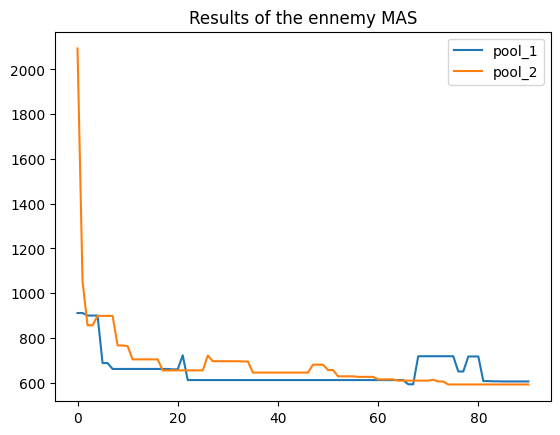

In [ ]:
sma_env.datacollector.get_model_vars_dataframe().plot(title='Results of the ennemy MAS')
plt.legend()